<a href="https://colab.research.google.com/github/Onyimatics/time_seres_heart_rate_prediction/blob/master/Heart_Rate_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00


In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import itertools
import sklearn
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from dateutil.parser import parse
from math import sqrt
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Loading the heart rete dataset

In [ ]:
heart_rate_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1qGL_DhVTU0Nc36Sl-I5VxHqyedJX5_zi')

# heart_rate_df = pd.read_csv('/content/PiDL1404505__Session_ID_1434__From_02_02_2016_15_39_11_to_05_02_2016_13_15_46__Exported_21_07_32.csv')

First five rows of the dataset

In [ ]:
heart_rate_df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,02/02/2016 15:39:00,NaN,NaN,NaN,NaN
1,02/02/2016 15:40:00,61442.0,61442.0,32.0,77.0
2,02/02/2016 15:41:00,61442.0,61442.0,-1.0,-1.0
3,02/02/2016 15:42:00,152.0,41.0,-1.0,-1.0
4,02/02/2016 15:43:00,149.0,39.0,98.0,149.0


Last five rows of the dataset

In [ ]:
heart_rate_df.tail()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN
225,17/08/2015 18:54,138,54,NaN,NaN


The number of rows and columns

In [ ]:
heart_rate_df.shape

(4177, 5)

View the columns names

In [ ]:
heart_rate_df.columns

Index(['Timestamp (GMT)', 'Lifetouch Heart Rate', 'Lifetouch Respiration Rate',
       'Oximeter SpO2', 'Oximeter Pulse'],
      dtype='object')

I will like to rename the columns for easy access

In [ ]:
heart_rate_df.columns = heart_rate_df.columns.str.strip() # remove unexpected spaces
heart_rate_df = heart_rate_df.rename(columns={"Timestamp (GMT)": "timestamp_gmt", "Lifetouch Heart Rate": "heart_rate",
                        "Lifetouch Respiration Rate": "respiration_rate", "Oximeter SpO2": "oximeter", "Oximeter Pulse": "oximeter_pulse"})
heart_rate_df.head()

,timestamp_gmt,heart_rate,respiration_rate,oximeter,oximeter_pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


Basic information about the data

In [ ]:
heart_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp_gmt     226 non-null    object 
 1   heart_rate        226 non-null    int64  
 2   respiration_rate  226 non-null    int64  
 3   oximeter          191 non-null    float64
 4   oximeter_pulse    191 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.0+ KB


Basic statistics of the data

In [ ]:
heart_rate_df.describe()

,heart_rate,respiration_rate,oximeter,oximeter_pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


Checking if there is any null value within the dataset

In [ ]:
heart_rate_df.isnull()

,timestamp_gmt,heart_rate,respiration_rate,oximeter,oximeter_pulse
0,False,False,False,True,True
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
221,False,False,False,True,True
222,False,False,False,True,True
223,False,False,False,True,True
224,False,False,False,True,True



Checking for duplicated values


In [ ]:
heart_rate_df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
221,False
222,False
223,False
224,False


There are no duplicate values from the above

Viewing null values in the rows althogether in total

In [ ]:
heart_rate_df.isna().sum()

,0
timestamp_gmt,0
heart_rate,0
respiration_rate,0
oximeter,35
oximeter_pulse,35


Checking the number of unique values of each columns

In [ ]:
heart_rate_df.nunique()

,0
timestamp_gmt,226
heart_rate,43
respiration_rate,32
oximeter,10
oximeter_pulse,35


Checking the type of the dataset columns

In [ ]:
heart_rate_df.dtypes

,0
timestamp_gmt,object
heart_rate,int64
respiration_rate,int64
oximeter,float64
oximeter_pulse,float64


Converting Timestamp (GMT) to a datetime format and set as Index

In [ ]:
heart_rate_df['timestamp_gmt']=pd.to_datetime(heart_rate_df['timestamp_gmt'])
heart_rate_df.set_index('timestamp_gmt', inplace=True)
heart_rate_df

<ipython-input-6-0cbcc647e677>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  heart_rate_df['timestamp_gmt']=pd.to_datetime(heart_rate_df['timestamp_gmt'])


,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
heart_rate_df.head()

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0


##INITIAL EDA

Countplot of heart rate

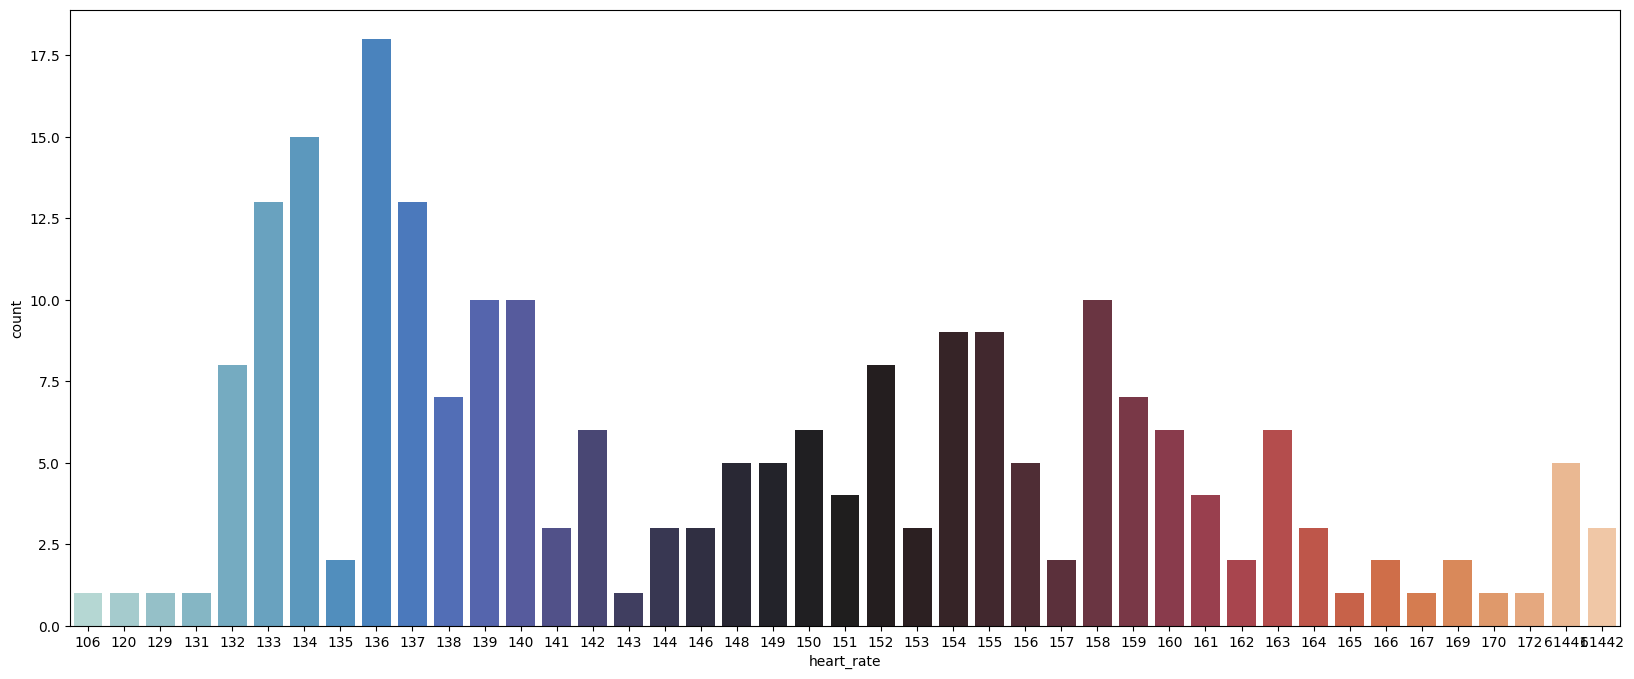

In [ ]:
from seaborn.widgets import color_palette
# palette = ['#1e3a5f', '#AA336A', '#D8BFD8']
plt.figure(figsize=(20, 8))
sns.countplot(x='heart_rate', data=heart_rate_df, palette='icefire')
plt.show()

Boxplot of heart rate

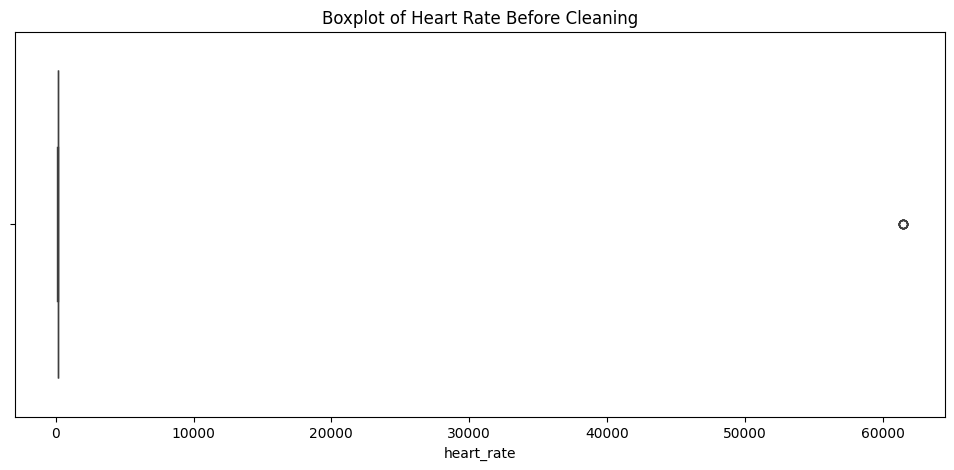

In [ ]:
# Plot raw heart rate data
plt.figure(figsize=(12, 5))
sns.boxplot(x='heart_rate', data=heart_rate_df)
plt.title("Boxplot of Heart Rate Before Cleaning")
plt.show()

Plot the Lifetouch Heart Rate over time

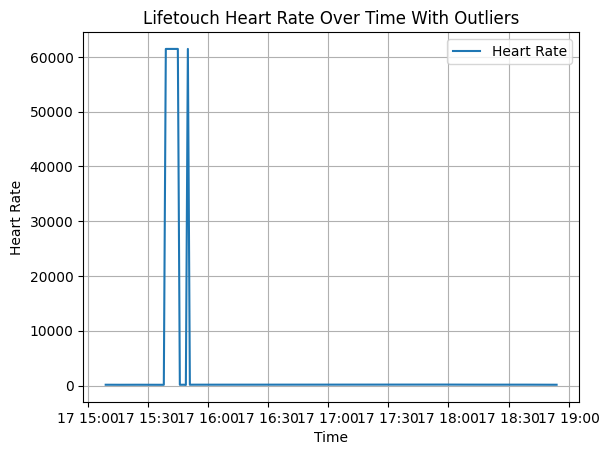

In [ ]:
# plt.figure(figsize=(10, 4))
plt.plot(heart_rate_df["heart_rate"], linestyle="-", label="Heart Rate")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Lifetouch Heart Rate Over Time With Outliers")
plt.legend()
plt.grid()
plt.show()

##DATA CLEANING

In [ ]:
heart_rate_df.isna().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,35
oximeter_pulse,35


In [ ]:
# Forward fill, then backward fill
heart_rate_df["oximeter"] = heart_rate_df["oximeter"].ffill().bfill()
heart_rate_df["oximeter_pulse"] = heart_rate_df["oximeter_pulse"].ffill().bfill()

# Verify if missing values are filled
heart_rate_df.isnull().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,0
oximeter_pulse,0


In [ ]:
heart_rate_df.shape

(226, 4)

In [ ]:
# # Step 2: Basic Cleaning

# # Remove duplicate rows
# df_cleaned = heart_rate_df.drop_duplicates()

# # Replace extreme outliers (heart rate > 250) with NaN
# df_cleaned["heart_rate"] = df_cleaned["heart_rate"].apply(lambda x: np.nan if x > 250 else x)

# # Replace negative values in oximeter and oximeter_pulse with NaN
# df_cleaned["oximeter"] = df_cleaned["oximeter"].apply(lambda x: np.nan if x < 0 else x)
# df_cleaned["oximeter_pulse"] = df_cleaned["oximeter_pulse"].apply(lambda x: np.nan if x < 0 else x)

# # Forward fill missing values to maintain continuity
# df_cleaned.ffill(inplace=True)

# # Resample data to ensure uniform 1-minute intervals
# df_resampled = df_cleaned.resample("1T").mean()

# # Plot cleaned heart rate data
# plt.figure(figsize=(12, 5))
# sns.boxplot(x=df_resampled["heart_rate"])
# plt.title("Boxplot of Heart Rate After Cleaning")
# plt.show()

# # Display cleaned dataset summary
# df_resampled.describe()


In [ ]:
# Check missing values
missing_values = heart_rate_df.isnull().sum()

# Display missing values in each column
missing_values

,0
heart_rate,0
respiration_rate,0
oximeter,0
oximeter_pulse,0


Check for extreme outliers

In [ ]:
heart_rate_df.shape

(226, 4)

In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
timestamp_gmt,,,,,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,139.000000,140.026300,140.040509,140.019284,140.031898
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,139.000000,139.290430,139.258729,139.314267,139.305214
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,139.041667,142.638929,142.594294,141.768554,141.772658
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,139.049653,140.754746,140.705342,141.781534,141.783124
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,139.040906,138.788093,138.737866,136.362838,136.515335
...,...,...,...,...,...,...,...,...,...
2015-08-17 18:50:00,159.0,51.0,-1.0,-1.0,147.849412,156.418288,156.361890,155.985558,155.781337
2015-08-17 18:51:00,151.0,64.0,-1.0,-1.0,147.942334,158.251593,158.194837,158.700652,158.428204
2015-08-17 18:52:00,140.0,64.0,-1.0,-1.0,147.967814,153.082847,153.025358,152.649539,152.587047


In [ ]:
# Detect Outliers Using IQR Method
def handle_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Outliers in {column}:")
    print(outliers)
    print(f"Number of outliers: {outliers.shape[0]}")

    # Replace outliers with NaN
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan

    # Interpolate missing values
    df[column].interpolate(method='linear', inplace=True)

    # Verify if outliers are removed
    outliers_after_cleaning = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutliers after cleaning in {column}:")
    print(outliers_after_cleaning)
    print(f"Number of remaining outliers: {outliers_after_cleaning.shape[0]}")

# Handle outliers for heart_rate
handle_outliers(heart_rate_df, "heart_rate")

# Handle outliers for respiration_rate
handle_outliers(heart_rate_df, "respiration_rate")

# Display the first few rows of the cleaned dataframe
print("\nCleaned dataframe:")
print(heart_rate_df.head())

# Check for any remaining NaN values
print("\nRemaining NaN values:")
print(heart_rate_df.isna().sum())


Outliers in heart_rate:
                     heart_rate  respiration_rate  oximeter  oximeter_pulse
timestamp_gmt                                                              
2015-08-17 15:39:00       61441             61441      94.0           152.0
2015-08-17 15:40:00       61442             61442      92.0           146.0
2015-08-17 15:41:00       61441             61441      -1.0            -1.0
2015-08-17 15:42:00       61441             61441      98.0           143.0
2015-08-17 15:43:00       61441             61441      97.0           142.0
2015-08-17 15:44:00       61441             61441      96.0           140.0
2015-08-17 15:45:00       61442             61442      96.0           144.0
2015-08-17 15:50:00       61442             61442      94.0           148.0
Number of outliers: 8

Outliers after cleaning in heart_rate:
Empty DataFrame
Columns: [heart_rate, respiration_rate, oximeter, oximeter_pulse]
Index: []
Number of remaining outliers: 0
Outliers in respiration_rate:


<ipython-input-8-47881176d26a>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].interpolate(method='linear', inplace=True)
<ipython-input-8-47881176d26a>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
# Oximeter Sp02
heart_rate_df.loc[heart_rate_df['oximeter'] < 0, 'oximeter'] = np.nan  # Treat negative values as missing
heart_rate_df['oximeter'] = heart_rate_df['oximeter'].interpolate(method='linear')  # Linear interpolation for missing values

# Handle Oximeter Pulse (negative values as NaN, ensure realistic range)
heart_rate_df.loc[heart_rate_df['oximeter_pulse'] < 0, 'oximeter_pulse'] = np.nan  # Treat negative values as missing
heart_rate_df.loc[heart_rate_df['oximeter_pulse'] > 200, 'oximeter_pulse'] = np.nan  # Cap high outliers (pulse > 200 bpm unlikely)
heart_rate_df['oximeter_pulse'] = heart_rate_df['oximeter_pulse'].interpolate(method='linear')  # Linear interpolation for missing values

# Ensure Oximeter Pulse stays within realistic range (60–200 bpm)
heart_rate_df['oximeter_pulse'] = heart_rate_df['oximeter_pulse'].clip(120, 200)  # Cap to realistic pulse range

# Check for missing values
print("Missing values after cleaning:\n", heart_rate_df.isna().sum())

Missing values after cleaning:
 heart_rate          0
respiration_rate    0
oximeter            0
oximeter_pulse      0
dtype: int64


In [ ]:
import pandas as pd

# Convert timestamp to datetime if not already
# heart_rate_df['timestamp_gmt'] = pd.to_datetime(heart_rate_df['timestamp_gmt'])

# Compute time difference between consecutive timestamps
heart_rate_df['time_diff'] = heart_rate_df.index.diff()

# Set a threshold (e.g., remove rows where gap is >1 day)
threshold = pd.Timedelta(days=1)
heart_rate_df = heart_rate_df[heart_rate_df['time_diff'] <= threshold]

# Drop the time_diff column (no longer needed)
heart_rate_df.drop(columns=['time_diff'], inplace=True)

# Now perform interpolation safely
heart_rate_df[['heart_rate', 'respiration_rate']] = heart_rate_df[['heart_rate', 'respiration_rate']].interpolate(method='linear')

# Check results
print(heart_rate_df.head())


                     heart_rate  respiration_rate  oximeter  oximeter_pulse
timestamp_gmt                                                              
2016-02-02 15:42:00       152.0              41.0      76.0           125.0
2016-02-02 15:43:00       149.0              39.0      98.0           149.0
2016-02-02 15:44:00       145.0              41.0      96.0           143.0
2016-02-02 15:45:00       143.0              36.0      97.0           142.0
2016-02-02 15:46:00       136.0              37.0      98.0           135.0


<ipython-input-117-b8661526e975>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_df['time_diff'] = heart_rate_df.index.diff()
<ipython-input-117-b8661526e975>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_df.drop(columns=['time_diff'], inplace=True)
<ipython-input-117-b8661526e975>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
# Interpolate NaN values in 'heart_rate' and 'respiration_rate' columns
heart_rate_df[['heart_rate', 'respiration_rate']] = heart_rate_df[['heart_rate', 'respiration_rate']].interpolate(method='linear')

In [ ]:
# Convert timestamp column to datetime if not already
heart_rate_df.index = pd.to_datetime(heart_rate_df.index)

# Check time differences between consecutive timestamps
time_diffs = heart_rate_df.index.to_series().diff().dropna()

# Display unique time intervals
print(time_diffs.value_counts())

timestamp_gmt
0 days 00:01:00     4161
28 days 00:04:00       1
30 days 00:04:00       1
29 days 00:04:00       1
Name: count, dtype: int64


In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2016-02-02 15:42:00,152.0,41.0,76.0,125.0
2016-02-02 15:43:00,149.0,39.0,98.0,149.0
2016-02-02 15:44:00,145.0,41.0,96.0,143.0
2016-02-02 15:45:00,143.0,36.0,97.0,142.0
2016-02-02 15:46:00,136.0,37.0,98.0,135.0
...,...,...,...,...
2016-02-02 20:37:00,155.0,45.0,91.0,145.0
2016-02-02 20:38:00,150.0,47.0,94.0,148.0
2016-02-02 20:39:00,146.0,40.0,91.0,149.0


In [ ]:
# Detect Outliers Using IQR Method

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = heart_rate_df["heart_rate"].quantile(0.25)
Q3 = heart_rate_df["heart_rate"].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = heart_rate_df[(heart_rate_df["heart_rate"] < lower_bound) | (heart_rate_df["heart_rate"] > upper_bound)]

# Display outliers
outliers, outliers.shape


(                     heart_rate  respiration_rate  oximeter  oximeter_pulse
 timestamp_gmt                                                              
 2015-08-17 15:39:00       61441             61441      94.0           152.0
 2015-08-17 15:40:00       61442             61442      92.0           146.0
 2015-08-17 15:41:00       61441             61441      -1.0            -1.0
 2015-08-17 15:42:00       61441             61441      98.0           143.0
 2015-08-17 15:43:00       61441             61441      97.0           142.0
 2015-08-17 15:44:00       61441             61441      96.0           140.0
 2015-08-17 15:45:00       61442             61442      96.0           144.0
 2015-08-17 15:50:00       61442             61442      94.0           148.0,
 (8, 4))

In [ ]:
# # Replace extreme outliers with NaN
# heart_rate_df.loc[(heart_rate_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# # Forward fill missing values to maintain continuity
# heart_rate_df.bfill(inplace=True)

# # Verify if outliers are removed
# outliers_after_cleaning = heart_rate_df[(heart_rate_df["heart_rate"] > upper_bound)]

# # Display remaining outliers (should be empty if all were handled)
# outliers_after_cleaning

In [ ]:
# Replace extreme outliers with NaN
heart_rate_df.loc[(heart_rate_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# Drop rows that now contain NaN values in the 'heart_rate' column
heart_rate_df.dropna(subset=["heart_rate"], inplace=True)

# Verify if any rows with extreme outliers remain
outliers_after_cleaning = heart_rate_df[heart_rate_df["heart_rate"] > upper_bound]
print(outliers_after_cleaning)


Empty DataFrame
Columns: [heart_rate, respiration_rate, oximeter, oximeter_pulse]
Index: []


In [ ]:
# 1. Ensure the index is a datetime index
heart_rate_df.index = pd.to_datetime(heart_rate_df.index)

# 2. Resample data to 1-minute intervals using the mean
heart_rate_df = heart_rate_df.resample("1T").mean()

# 3. Drop any rows with missing values (if desired)
heart_rate_df.dropna(inplace=True)

# Check the first few rows of the resampled DataFrame
print(heart_rate_df.head())

                     heart_rate  respiration_rate  oximeter  oximeter_pulse
timestamp_gmt                                                              
2015-08-17 15:09:00       139.0              41.0      92.0           140.0
2015-08-17 15:10:00       144.0              40.0      92.0           140.0
2015-08-17 15:11:00       140.0              42.0      89.0           144.0
2015-08-17 15:12:00       138.0              45.0      93.0           141.0
2015-08-17 15:13:00       133.0              42.0      94.0           134.0


<ipython-input-31-9372288a1ddb>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  heart_rate_df = heart_rate_df.resample("1T").mean()


In [ ]:
heart_rate_df['time_diff'] = heart_rate_df.index.to_series().diff().dropna()  # Calculate time differences
print(heart_rate_df['time_diff'].value_counts())  # Check unique time gaps

time_diff
0 days 00:01:00    215
0 days 00:08:00      1
0 days 00:02:00      1
Name: count, dtype: int64


In [ ]:
heart_rate_df.head()

,heart_rate,respiration_rate,oximeter,oximeter_pulse,time_diff
timestamp_gmt,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,NaT
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,0 days 00:01:00
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,0 days 00:01:00
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,0 days 00:01:00
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,0 days 00:01:00


In [ ]:
# Create a complete 1-minute timestamp range
full_index = pd.date_range(start=heart_rate_df.index.min(), end=heart_rate_df.index.max(), freq='min')

# Reindex the dataframe to fill missing timestamps
heart_rate_df = heart_rate_df.reindex(full_index)

# Optionally, fill missing values using forward fill (or other methods)
# heart_rate_df['heart_rate'].fillna(method='ffill', inplace=True)

# Now check if the frequency is properly inferred
print(heart_rate_df.index.inferred_freq)  # Should return 'T'

min


In [ ]:
heart_rate_df['time_diff'] = heart_rate_df.index.to_series().diff().dropna()  # Calculate time differences
print(heart_rate_df['time_diff'].value_counts())  # Check unique time gaps

time_diff
0 days 00:01:00    225
Name: count, dtype: int64


In [ ]:
# # Replace extreme outliers with NaN
# heart_rate_df.loc[(heart_rate_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# # Interpolate missing values using time-based interpolation
# heart_rate_df.interpolate(method='time', inplace=True)

# # Verify if outliers are removed (should be empty if all were handled)
# outliers_after_cleaning = heart_rate_df[(heart_rate_df["heart_rate"] > upper_bound)]
# print(outliers_after_cleaning)

In [ ]:
heart_rate_df.describe()

,heart_rate,respiration_rate,oximeter,oximeter_pulse,time_diff
count,226.000000,226.000000,226.000000,226.000000,225
mean,145.353982,45.705752,73.367257,111.495575,0 days 00:01:00
std,11.457578,7.831594,39.245581,60.339134,0 days 00:00:00
min,106.000000,34.000000,-1.000000,-1.000000,0 days 00:01:00
25%,136.000000,38.000000,92.000000,133.000000,0 days 00:01:00
50%,142.000000,45.000000,93.000000,137.000000,0 days 00:01:00
75%,155.000000,52.000000,95.000000,148.000000,0 days 00:01:00
max,172.000000,64.000000,98.000000,166.000000,0 days 00:01:00


In [ ]:
heart_rate_df.shape

(226, 5)

In [ ]:
# heart_rate_df.index = pd.to_datetime(heart_rate_df.index)  # Ensure datetime format
# heart_rate_df["time_diff"] = heart_rate_df.index.diff()  # Compute time differences

# heart_rate_df["time_diff"].value_counts()  # Show frequency of time intervals


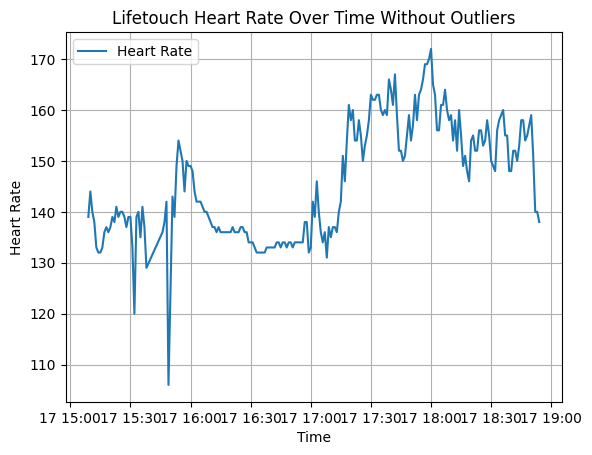

In [ ]:
# plt.figure(figsize=(12, 5))
plt.plot(heart_rate_df["heart_rate"], linestyle="-", label="Heart Rate")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Lifetouch Heart Rate Over Time Without Outliers")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(heart_rate_df[heart_rate_df.isnull().any(axis=1)])

Empty DataFrame
Columns: [heart_rate, respiration_rate, oximeter, oximeter_pulse]
Index: []


In [ ]:
heart_rate_df['heart_rate'].isna().sum()

0

In [ ]:
heart_rate_df.shape

(226, 5)

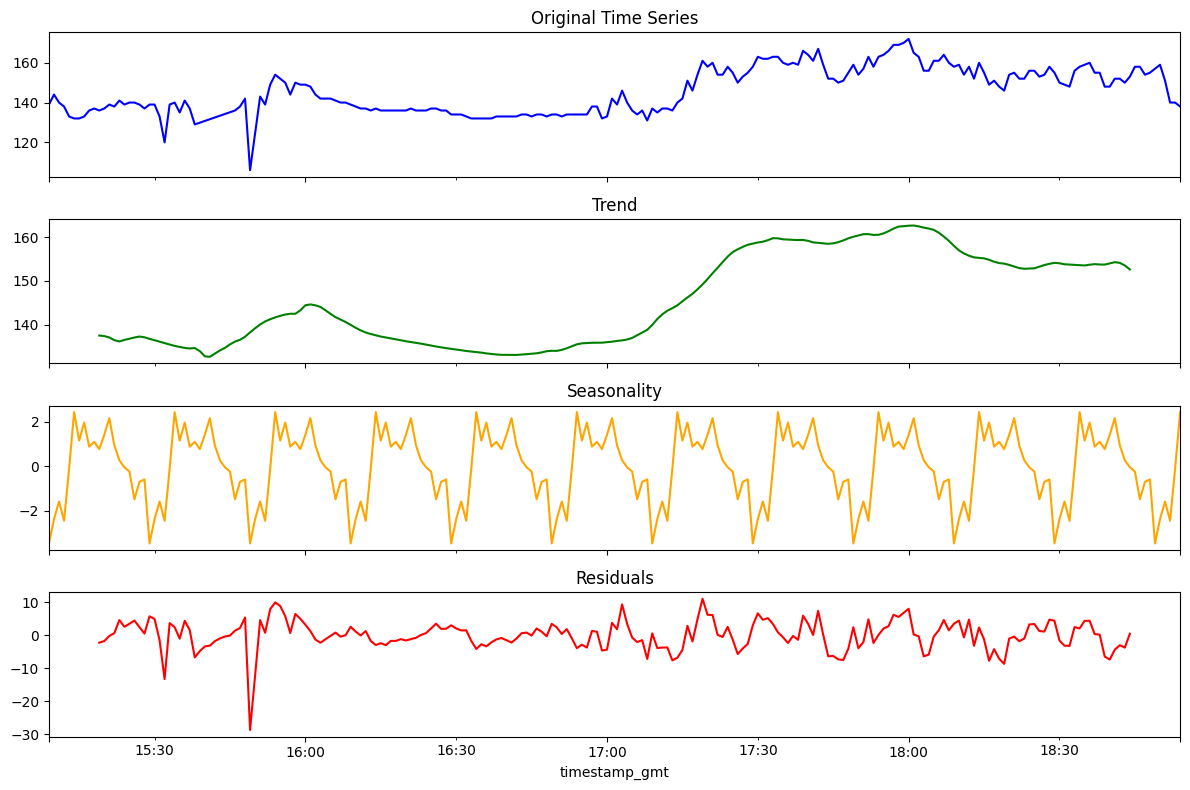

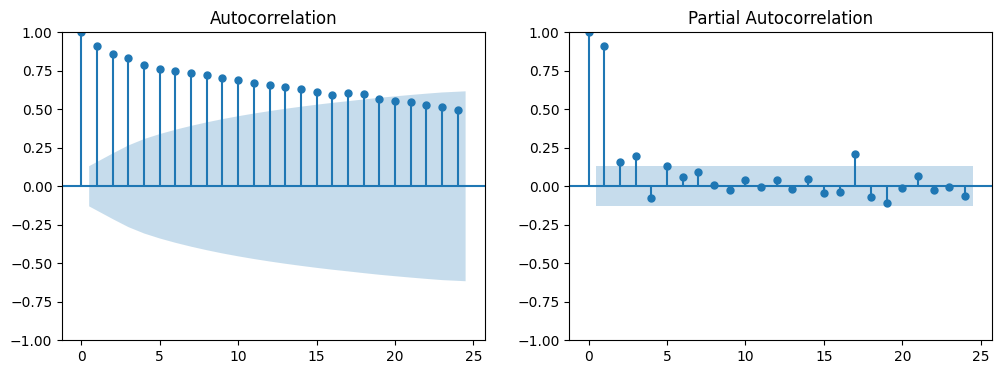

(-2.059379131280545, 0.2611588743274905)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 3: Detailed EDA (After Cleaning)

# ADF Test for Stationarity
adf_result = adfuller(heart_rate_df["heart_rate"])  # Drop NaN to avoid issues
adf_statistic, p_value = adf_result[0], adf_result[1]

# Time Series Decomposition
decomposition = seasonal_decompose(heart_rate_df["heart_rate"].dropna(), model="additive", period=20)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

heart_rate_df["heart_rate"].plot(ax=axes[0], title="Original Time Series", color="blue")
decomposition.trend.plot(ax=axes[1], title="Trend", color="green")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality", color="orange")
decomposition.resid.plot(ax=axes[3], title="Residuals", color="red")

plt.tight_layout()
plt.show()

# Autocorrelation Plots (ACF & PACF)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(heart_rate_df["heart_rate"].dropna(), ax=axes[0])
plot_pacf(heart_rate_df["heart_rate"].dropna(), ax=axes[1])
plt.show()

# Display ADF Test results
adf_statistic, p_value


In [ ]:
heart_rate_df

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0
2015-08-17 15:11:00,140.0,42.0,89.0,144.0
2015-08-17 15:12:00,138.0,45.0,93.0,141.0
2015-08-17 15:13:00,133.0,42.0,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159.0,51.0,-1.0,-1.0
2015-08-17 18:51:00,151.0,64.0,-1.0,-1.0
2015-08-17 18:52:00,140.0,64.0,-1.0,-1.0


##DATA PREPROCESSING

In [ ]:
# #Dropping unwanted columns
# heart_rate_df = heart_rate_df.drop(columns=['respiration_rate','oximeter','oximeter_pulse'])
# heart_rate_df

,heart_rate,time_diff
2015-08-17 15:09:00,139.0,NaT
2015-08-17 15:10:00,144.0,0 days 00:01:00
2015-08-17 15:11:00,140.0,0 days 00:01:00
2015-08-17 15:12:00,138.0,0 days 00:01:00
2015-08-17 15:13:00,133.0,0 days 00:01:00
...,...,...
2015-08-17 18:50:00,159.0,0 days 00:01:00
2015-08-17 18:51:00,151.0,0 days 00:01:00
2015-08-17 18:52:00,140.0,0 days 00:01:00
2015-08-17 18:53:00,140.0,0 days 00:01:00


##STATIONARITY

In [ ]:

# convert Timestamp to int
heart_rate_df['minute'] = list(range(0, len(heart_rate_df.index)))

heart_rate_df.head()

,heart_rate,respiration_rate,oximeter,oximeter_pulse,minute
timestamp_gmt,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,1
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,2
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,3
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4


KPSS Test For Stationarity

In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value} ')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(heart_rate_df["heart_rate"])

p value: 0.01 
Result: The series is not stationary 



<ipython-input-37-fae7ac604b1b>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


In [ ]:
# heart_rate_df['heart_rate_diff'] = heart_rate_df["heart_rate"].diff().dropna()
# heart_rate_df.head(15)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,time_diff,minute,heart_rate_diff
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,NaT,0,NaN
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,0 days 00:01:00,1,5.0
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,0 days 00:01:00,2,-4.0
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,0 days 00:01:00,3,-2.0
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,0 days 00:01:00,4,-5.0
2015-08-17 15:14:00,132.0,41.0,92.0,134.0,0 days 00:01:00,5,-1.0
2015-08-17 15:15:00,132.0,47.0,92.0,135.0,0 days 00:01:00,6,0.0
2015-08-17 15:16:00,133.0,44.0,92.0,135.0,0 days 00:01:00,7,1.0
2015-08-17 15:17:00,136.0,45.0,94.0,136.0,0 days 00:01:00,8,3.0
2015-08-17 15:18:00,137.0,42.0,93.0,138.0,0 days 00:01:00,9,1.0


In [ ]:
# # plot time series
# plt.figure(figsize=(12, 8))
# plt.plot(heart_rate_df['minute'],heart_rate_df['heart_rate_diff'].values)
# plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30)) # define x-axis step size
# plt.show()

In [ ]:
# check_stationarity(heart_rate_df['heart_rate_diff'].dropna())

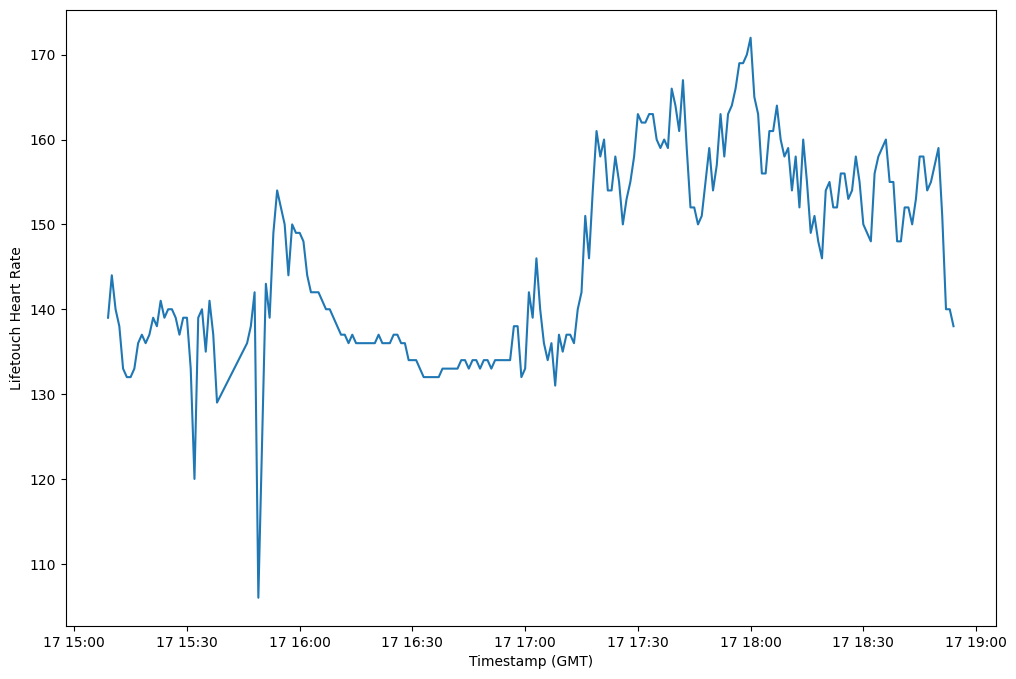

In [ ]:

# plot time series
#Because it has been set to an index, the word Timestamp (GMT) would not be used, instead heart_rate_df.index
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df.index,heart_rate_df['heart_rate'])
plt.xlabel('Timestamp (GMT)')
plt.ylabel('Lifetouch Heart Rate')
plt.show()

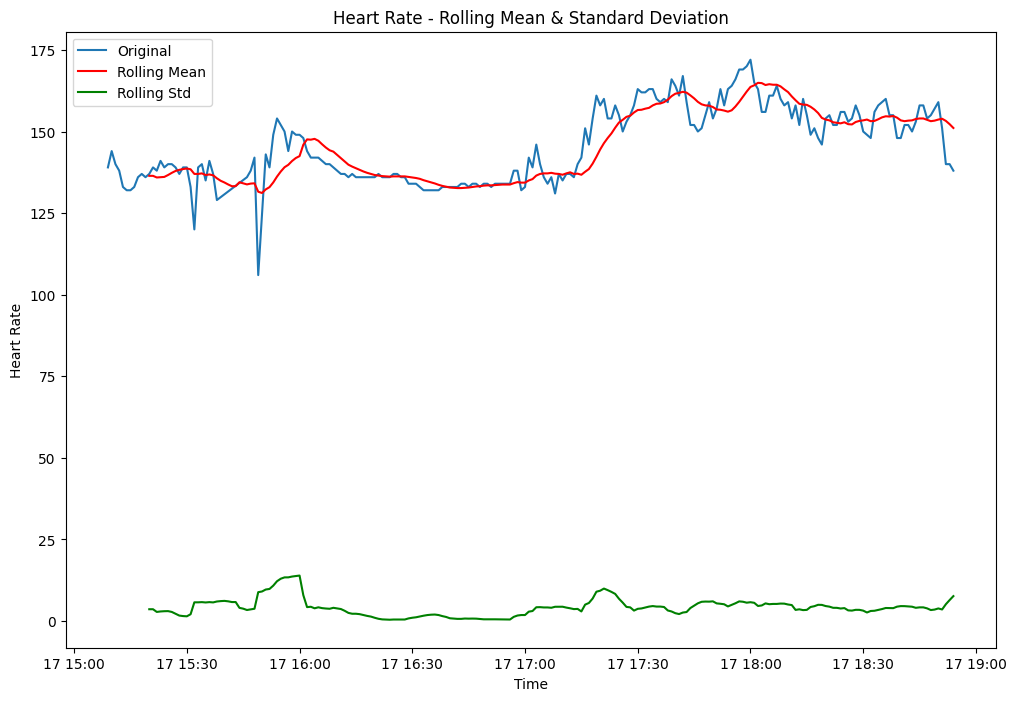

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = heart_rate_df['heart_rate'].rolling(window=12).mean()
rolling_std = heart_rate_df['heart_rate'].rolling(window=12).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12,8))
plt.plot(heart_rate_df.index, heart_rate_df['heart_rate'], label='Original')
plt.plot(heart_rate_df.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(heart_rate_df.index, rolling_std, label='Rolling Std', color='green')
plt.title('Heart Rate - Rolling Mean & Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

By looking at the plot above, I can conclude that, it is non-stationary because mean and variance is not constant.

Log Transformation

In [ ]:
# add new column 'log_heart_rate' with log transformed values
heart_rate_df['log_heart_rate'] = np.log(heart_rate_df['heart_rate'])

print(heart_rate_df.shape)
heart_rate_df.head()

(226, 6)


,heart_rate,respiration_rate,oximeter,oximeter_pulse,minute,log_heart_rate
timestamp_gmt,,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,0,4.934474
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,1,4.969813
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,2,4.941642
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,3,4.927254
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4,4.890349


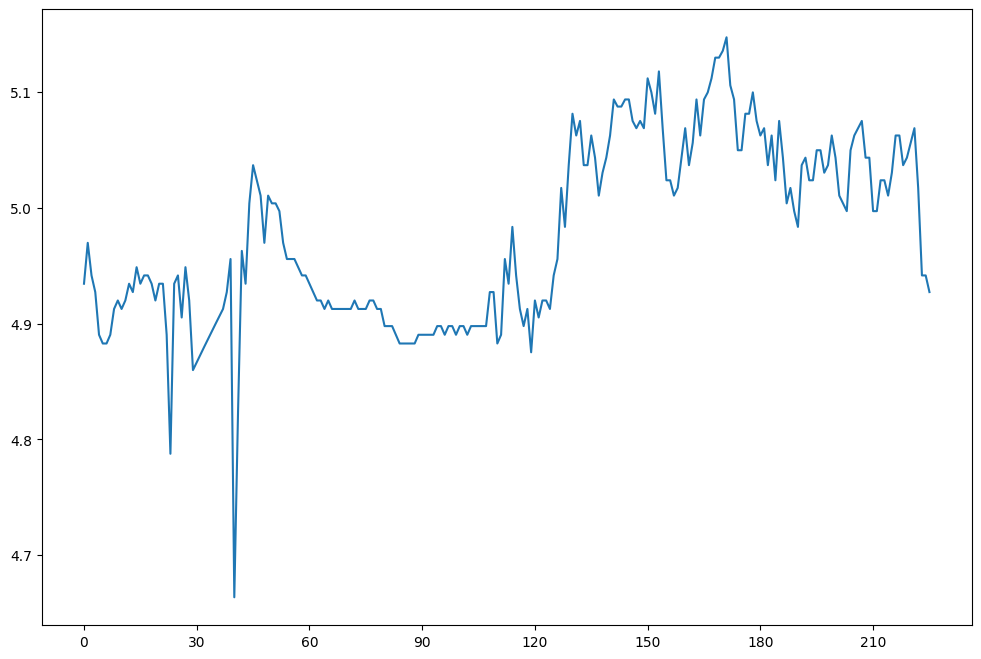

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['log_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30)) # define x-axis step size
plt.show()

Deseasonalisation

In [ ]:
heart_rate_df['deseasonalised_heart_rate'] = heart_rate_df[['log_heart_rate']].diff(axis=0, periods=12)
heart_rate_df.head(15)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,minute,log_heart_rate,deseasonalised_heart_rate
timestamp_gmt,,,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,0,4.934474,NaN
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,1,4.969813,NaN
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,2,4.941642,NaN
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,3,4.927254,NaN
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4,4.890349,NaN
2015-08-17 15:14:00,132.0,41.0,92.0,134.0,5,4.882802,NaN
2015-08-17 15:15:00,132.0,47.0,92.0,135.0,6,4.882802,NaN
2015-08-17 15:16:00,133.0,44.0,92.0,135.0,7,4.890349,NaN
2015-08-17 15:17:00,136.0,45.0,94.0,136.0,8,4.912655,NaN


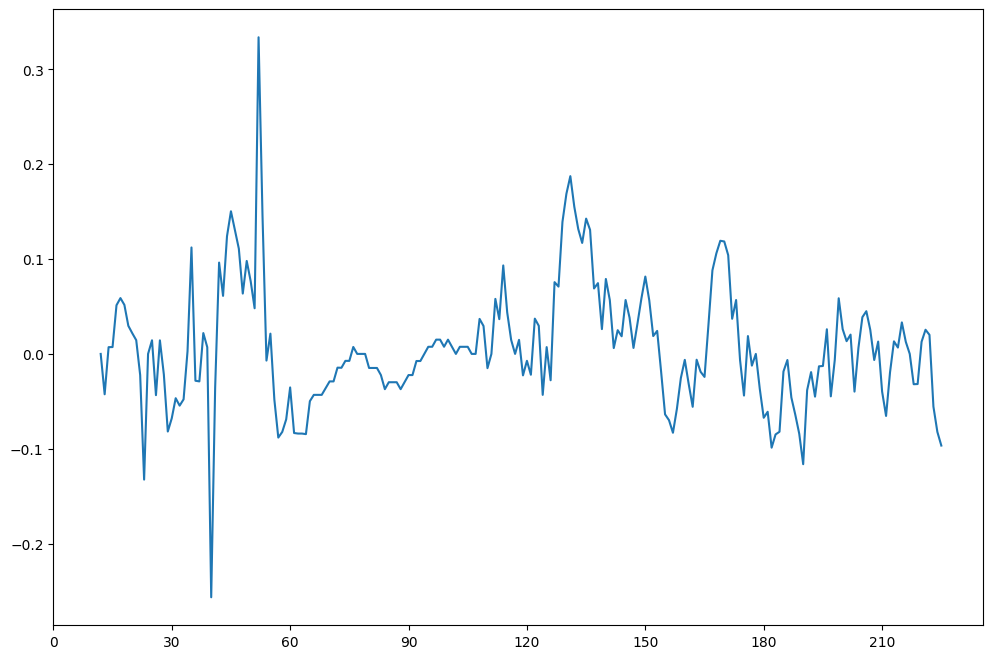

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['deseasonalised_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30)) # define x-axis step size
plt.show()

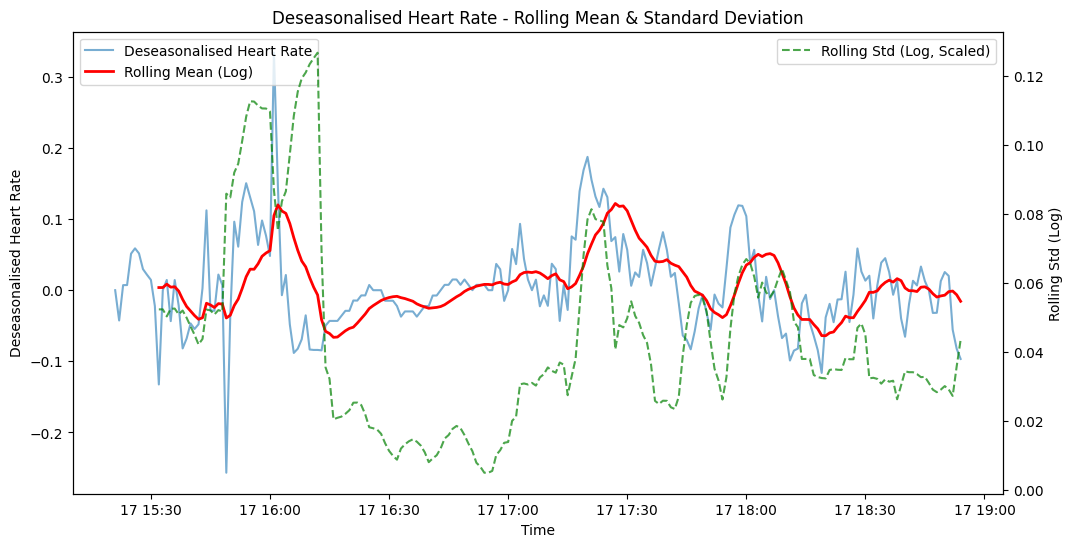

In [ ]:
# Calculate rolling mean and standard deviation for Deseasonalised heart rate
rolling_mean_log = heart_rate_df['deseasonalised_heart_rate'].rolling(window=12).mean()
rolling_std_log = heart_rate_df['deseasonalised_heart_rate'].rolling(window=12).std()

# Plot the original Deseasonalised data and rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(heart_rate_df.index, heart_rate_df['deseasonalised_heart_rate'], label='Deseasonalised Heart Rate', alpha=0.6)
plt.plot(rolling_mean_log.index, rolling_mean_log, label='Rolling Mean (Log)', color='red', linewidth=2)

# Add secondary y-axis for standard deviation
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(rolling_std_log.index, rolling_std_log, label='Rolling Std (Log, Scaled)', color='green', linestyle='dashed', alpha=0.7)

# Labels and legend
ax.set_title('Deseasonalised Heart Rate - Rolling Mean & Standard Deviation')
ax.set_xlabel('Time')
ax.set_ylabel('Deseasonalised Heart Rate')
ax2.set_ylabel('Rolling Std (Deseasonalised)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Differencing

In [ ]:
heart_rate_df['differenced_heart_rate'] = heart_rate_df[['deseasonalised_heart_rate']].diff(axis=0, periods=1)
heart_rate_df.head(15)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,minute,log_heart_rate,deseasonalised_heart_rate,differenced_heart_rate
timestamp_gmt,,,,,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0,0,4.934474,NaN,NaN
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,1,4.969813,NaN,NaN
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,2,4.941642,NaN,NaN
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,3,4.927254,NaN,NaN
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4,4.890349,NaN,NaN
2015-08-17 15:14:00,132.0,41.0,92.0,134.0,5,4.882802,NaN,NaN
2015-08-17 15:15:00,132.0,47.0,92.0,135.0,6,4.882802,NaN,NaN
2015-08-17 15:16:00,133.0,44.0,92.0,135.0,7,4.890349,NaN,NaN
2015-08-17 15:17:00,136.0,45.0,94.0,136.0,8,4.912655,NaN,NaN


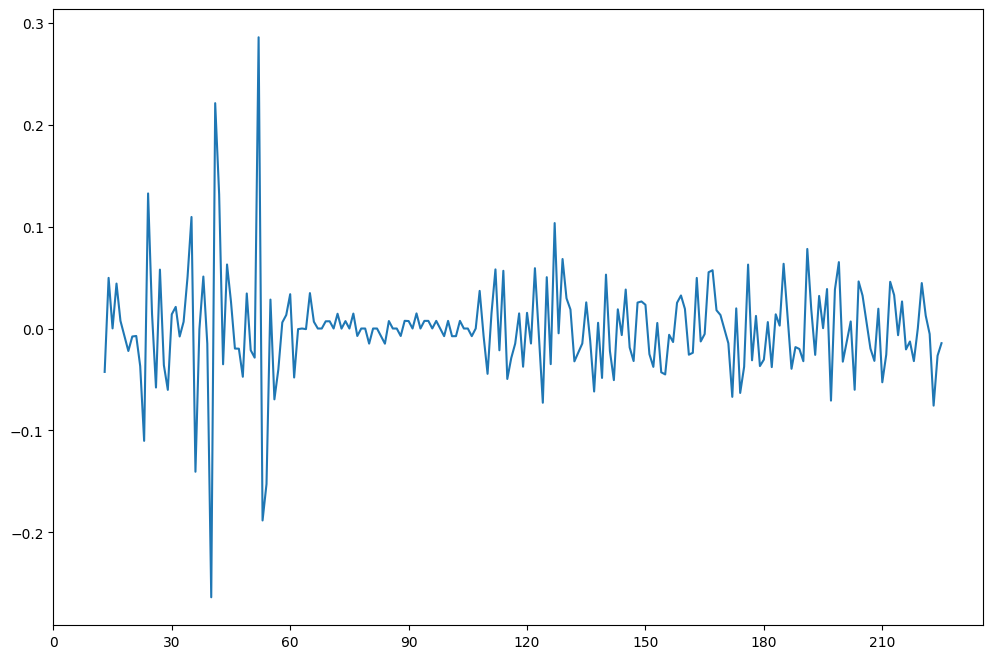

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['differenced_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30))  # define x-axis step size
plt.show()

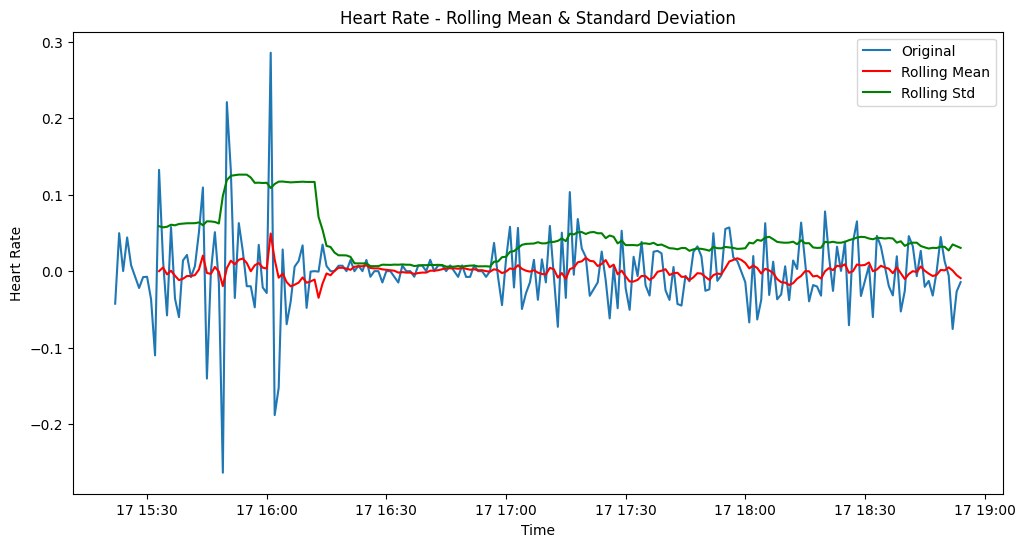

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = heart_rate_df['differenced_heart_rate'].rolling(window=12).mean()
rolling_std = heart_rate_df['differenced_heart_rate'].rolling(window=12).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12,6))
plt.plot(heart_rate_df.index, heart_rate_df['differenced_heart_rate'], label='Original')
plt.plot(heart_rate_df.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(heart_rate_df.index, rolling_std, label='Rolling Std', color='green')
plt.title('Heart Rate - Rolling Mean & Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

In [ ]:
check_stationarity(heart_rate_df['differenced_heart_rate'][13:])

p value: 0.1 
Result: The series is stationary 



<ipython-input-37-fae7ac604b1b>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)


In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0
2015-08-17 15:11:00,140.0,42.0,89.0,144.0
2015-08-17 15:12:00,138.0,45.0,93.0,141.0
2015-08-17 15:13:00,133.0,42.0,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159.0,51.0,95.0,120.0
2015-08-17 18:51:00,151.0,64.0,95.0,120.0
2015-08-17 18:52:00,140.0,64.0,95.0,120.0


ARIMA is not suitable for this task because the dataset exhibits strong seasonality, which ARIMA cannot handle effectively.

Therefore, my first model is SARIMA which explicitly models seasonal patterns.

##**MODEL *** - ARIMA**

###**SINCE THE DATA IS SEASONAL ANND HAS TRENDS, I WILL NOT USE ARIMA. HOWEVER, LET ME PLAY AROUND IT**

Splitting Dataset

In [ ]:
# X = heart_rate_df["heart_rate"].values
# X = heart_rate_df["heart_rate"].dropna().values

# # Train-test split (70% train, 30% test)
# size = int(len(X) * 0.70)
# train, test = X[:size], X[size:]

# Find the best ARIMA(p, d, q) automatically
# auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
# print(f"Best ARIMA Order: {auto_model.order}")

In [ ]:
# # Use best order from Auto ARIMA
# # best_p, best_d, best_q = auto_model.order

# # Train ARIMA model on history
# history = list(train)
# predictions = []

# # Walk-forward validation
# for t in range(len(test)):
#     model = ARIMA(history, order=(2, 1, 2))
#     model_fit = model.fit()

#     yhat = model_fit.forecast()[0]  # Predict next step
#     predictions.append(yhat)

#     history.append(test[t])  # Update history

# # Evaluate MSE & RMSE
# mse = mean_squared_error(test, predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(test, predictions)

# print(f"Optimized ARIMA MSE: {mse:.4f}")
# print(f"Optimized ARIMA RMSE: {rmse:.4f}")
# print(f"Optimized ARIMA MAE: {rmse:.4f}")

Optimized ARIMA MSE: 16.5336
Optimized ARIMA RMSE: 4.0662
Optimized ARIMA MAE: 4.0662


In [ ]:
from scipy.special import inv_boxcox
# Use best order from Auto ARIMA
# best_p, best_d, best_q = auto_model.order
X = heart_rate_df["heart_rate"].dropna().values

# Train-test split (70% train, 30% test)
size = int(len(X) * 0.70)
train, test = X[:size], X[size:]

# Train ARIMA model on history
history = list(train)
predictions = []


# Initialize history with training data
history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Fit ARIMA model on the current history
    model = ARIMA(history, order=(1, 0, 1))
    model_fit = model.fit()

    # Forecast the next step (1 step ahead)
    yhat = model_fit.forecast()[0]  # Only get the first forecasted value
    predictions.append(yhat)

    # Store the actual observation
    obs = test[t]
    history.append(obs)

    # print(f'Predicted={yhat:.2f}, Expected={obs:.2f}')

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# import numpy as np

# # Use best order from Auto ARIMA
# # best_p, best_d, best_q = auto_model.order
# X = heart_rate_df["heart_rate"].dropna().values

# # Train-test split (70% train, 30% test)
# size = int(len(X) * 0.70)
# train, test = X[:size], X[size:]

# # Initialize history with training data
# history = list(train)
# predictions = []

# # Walk-forward validation
# for t in range(len(test)):
#     model = ARIMA(history, order=(2, 2, 2))  # Fit ARIMA model on history
#     model_fit = model.fit()

#     yhat = model_fit.forecast()[0]  # 1-step ahead forecast
#     predictions.append(yhat)

#     obs = test[t]  # Store actual observation
#     history.append(obs)

#     print(f'Predicted={yhat:.2f}, Expected={obs:.2f}')


##MODEL EVALUATION

ARIMA MSE: 17.3067
ARIMA RMSE: 4.1601
ARIMA MAE: 4.1601


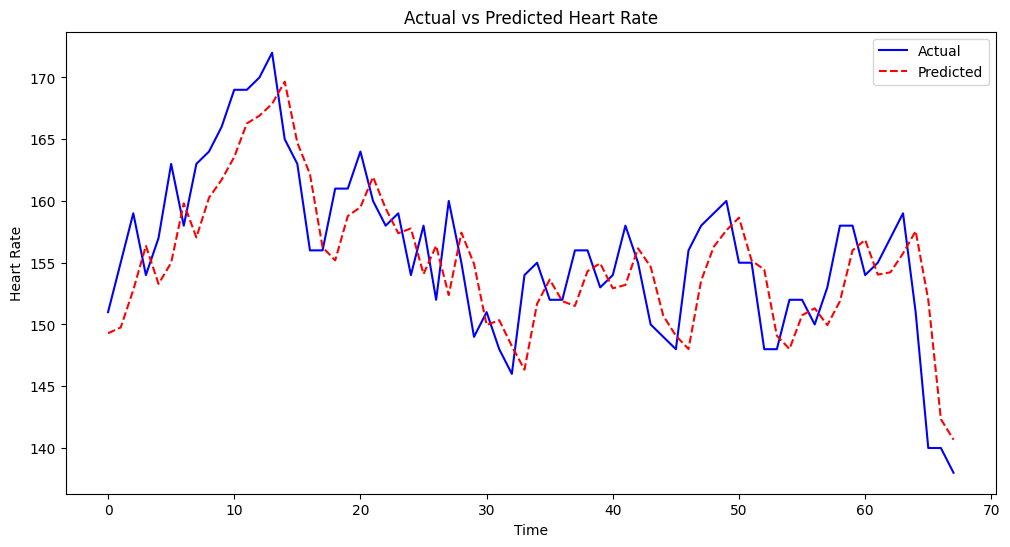

In [ ]:
# Evaluate MSE & RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f"ARIMA MSE: {mse:.4f}")
print(f"ARIMA RMSE: {rmse:.4f}")
print(f"ARIMA MAE: {rmse:.4f}")

# Plot Observations vs. Predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", color='blue')
plt.plot(predictions, label="Predicted", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Actual vs Predicted Heart Rate")
plt.legend()
plt.show()

In [ ]:
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)

AIC: 1368.7566491761293
BIC: 1382.4210507849468


In [ ]:
# # Train ARIMA on the **entire dataset** for out-of-sample forecasting
# final_model = ARIMA(X, order=(2, 2, 2))
# final_model_fit = final_model.fit()

# # Forecast next 20 steps
# forecast = final_model_fit.forecast(steps=20)
# print("Next 20 predicted values:")
# print(forecast)

In [ ]:
# # Out-of-sample forecasts
# forecast = model_fit.forecast(steps=20)
# print(forecast)

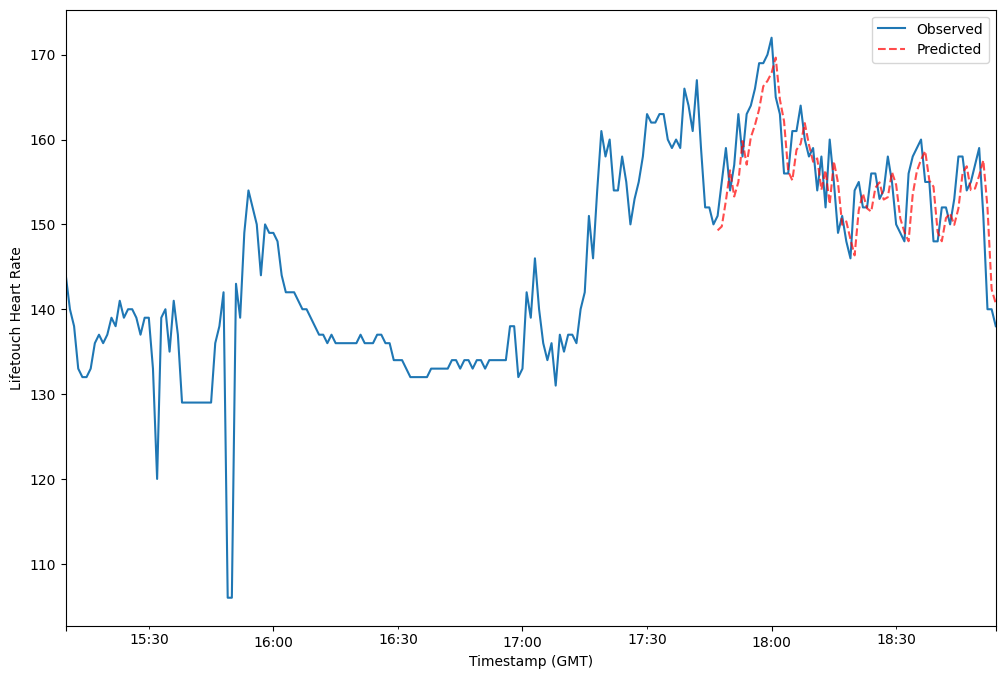

In [ ]:
# Convert predictions list to a Pandas Series and align it with the test data index
predictions_series = pd.Series(predictions, index=heart_rate_df.index[size:])

# Plot observed values
ax = heart_rate_df.loc['2015-08-17 15:10:00':, 'heart_rate'].plot(label='Observed', figsize=(12, 8))

# Plot predicted values
predictions_series.loc['2015-08-17 15:10:00':].plot(ax=ax, label='Predicted', alpha=0.7, linestyle="dashed", color="red")

# Labels and legend
ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()
plt.show()

In [ ]:
# Use Auto ARIMA to find best (p, d=0, q)
auto_model = auto_arima(heart_rate_df['heart_rate'], seasonal=True, stepwise=True, trace=True)
best_p, best_d, best_q = auto_model.order
print(f"Best ARIMA Order: {best_p}, {best_d}, {best_q}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1353.287, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1376.400, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1375.121, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1372.120, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1374.400, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1354.721, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1360.160, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1353.967, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1354.362, Time=2.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1360.461, Time=0.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1355.640, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1360.731, Time=1.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1355.190, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1351.347, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1352.723, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1358.161, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1352.066, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1352.458, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1358.560, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1353.647, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1358.731, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1353.281, Time=0.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 14.139 seconds
Best ARIMA Order: 2, 1, 2


In [ ]:
# Fit ARIMA model with optimized (p, d=0, q)
arima_model = ARIMA(heart_rate_df['heart_rate'].dropna(), order=(1, 0, 1))
arima_result = arima_model.fit()

# Generate in-sample predictions
heart_rate_df['ARIMA_Predicted'] = arima_result.fittedvalues

ARIMA MSE: 24.623601150454096


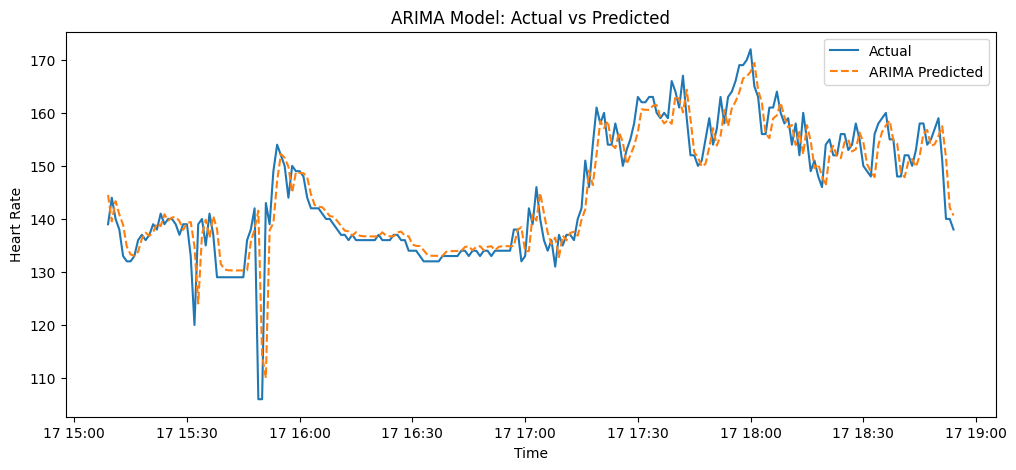

In [ ]:
# Evaluate model performance
mse_arima = mean_squared_error(heart_rate_df['heart_rate'].dropna(), heart_rate_df['ARIMA_Predicted'].dropna())
print(f"ARIMA MSE: {mse_arima}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(heart_rate_df['heart_rate'], label="Actual")
plt.plot(heart_rate_df['ARIMA_Predicted'], label="ARIMA Predicted", linestyle="dashed")
plt.title("ARIMA Model: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.legend()
plt.show()

In [ ]:
rmse_arima = np.sqrt(mse_arima)
print(f"ARIMA RMSE: {rmse_arima}")

ARIMA RMSE: 4.962217362274057


In [ ]:
print("AIC:", arima_result.aic)
print("BIC:", arima_result.bic)


AIC: 1374.0845230757532
BIC: 1387.7666630728422


In [ ]:
# Forecast next 20 time steps
forecast_steps = 20
arima_forecast = arima_result.forecast(steps=forecast_steps)

# Extend time index for future predictions
# future_dates = pd.date_range(start=heart_rate_df.index[-1], periods=forecast_steps + 1, freq='T')[1:]

In [ ]:
arima_forecast

,predicted_mean
2015-08-17 18:55:00,138.872442
2015-08-17 18:56:00,139.264732
2015-08-17 18:57:00,139.629777
2015-08-17 18:58:00,139.969470
2015-08-17 18:59:00,140.285570
2015-08-17 19:00:00,140.579716
2015-08-17 19:01:00,140.853433
2015-08-17 19:02:00,141.108140
2015-08-17 19:03:00,141.345157
2015-08-17 19:04:00,141.565713


In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)

Test RMSE: 4.160
Test MAE: 3.497


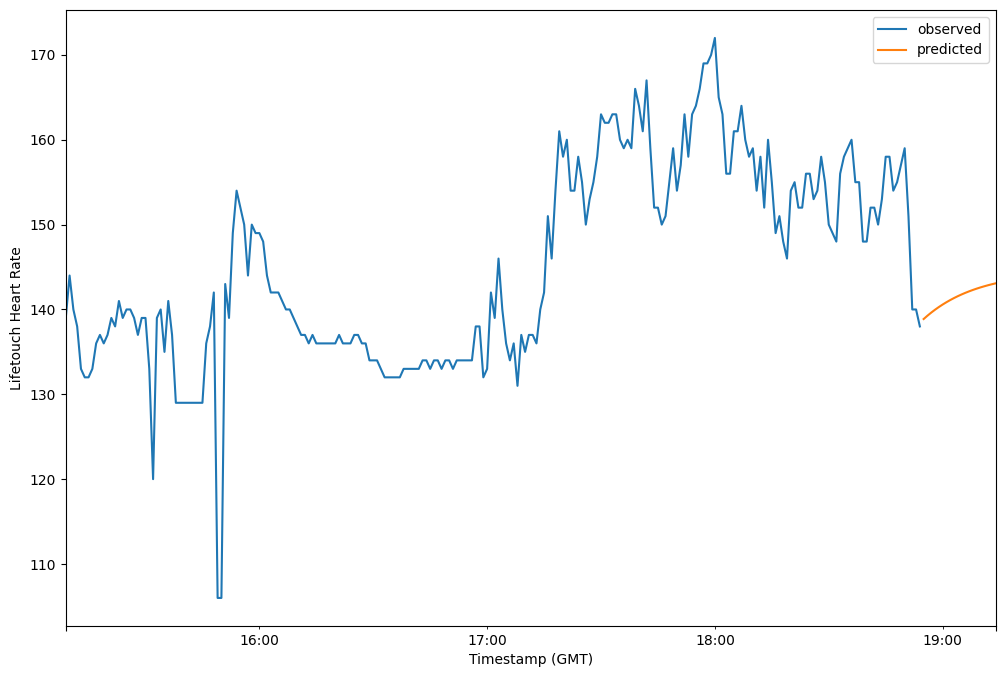

In [ ]:
# plot observations and predictions
ax = heart_rate_df['heart_rate'].plot(label='observed', figsize=(12, 8))
arima_forecast.plot(ax=ax, label='predicted')

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

##**MODEL 1 - SARIMA**

In [ ]:

# p = d = q = range(0, 3)

# # generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
# # generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# seasonal_pdq = [(1, 1, 1, 12)]

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#           mod = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
#                                           order=param,
#                                           seasonal_order=param_seasonal,
#                                           enforce_stationarity=False,
#                                           enforce_invertibility=False)

#           mod_fit = mod.fit()

#           print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

import itertools
import statsmodels.api as sm
import pandas as pd

warnings.filterwarnings('ignore')
# Define p, d, q ranges
p = d = q = range(0, 3)  # Adjust range if needed

# Generate all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate seasonal pdq (assuming seasonal period of 12)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Initialize variables to track the best model
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Loop through all combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                heart_rate_df['heart_rate'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            mod_fit = mod.fit(disp=False)  # Fit the model
            aic = mod_fit.aic  # Get AIC score

            print(f'ARIMA{param}x{param_seasonal} - AIC: {aic}')

            # Track the best model
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = mod_fit

        except Exception as e:
            print(f"Error fitting ARIMA{param}x{param_seasonal}: {e}")

# Print the best model
print(f"\nBest Model: ARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {best_aic}")


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 2882.628439636137
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC: 2486.003877991111
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC: 2163.701693316665
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC: 1553.3032908017844
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC: 1454.9728928047434
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC: 1377.9950810593423
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC: 1660.876619567279
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC: 1415.5174620827672
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC: 1300.1827309008986
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC: 1560.8767331292554
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC: 1535.1045677756956
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC: 1450.4518580093472
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC: 1463.2870564601344
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC: 1458.7540510850417
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC: 1379.8376257703176
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC: 1493.8424392812851
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC: 1412.213606642768
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC: 1311.5819513578188
ARIMA(0, 0, 0)x

In [ ]:
p = d = q = range(0, 4)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 0, 3, 60)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 0, 3, 60)12 - AIC:353.6024572931268
ARIMA(0, 0, 1)x(1, 0, 3, 60)12 - AIC:309.0860153979673
ARIMA(0, 0, 2)x(1, 0, 3, 60)12 - AIC:302.89625429294074
ARIMA(0, 0, 3)x(1, 0, 3, 60)12 - AIC:285.4922971180228
ARIMA(0, 1, 0)x(1, 0, 3, 60)12 - AIC:256.81870025456624
ARIMA(0, 1, 1)x(1, 0, 3, 60)12 - AIC:252.77457404200533
ARIMA(0, 1, 2)x(1, 0, 3, 60)12 - AIC:245.7838381950273
ARIMA(0, 1, 3)x(1, 0, 3, 60)12 - AIC:238.1252837468301
ARIMA(0, 2, 0)x(1, 0, 3, 60)12 - AIC:283.6541152192838
ARIMA(0, 2, 1)x(1, 0, 3, 60)12 - AIC:249.9085740732864
ARIMA(0, 2, 2)x(1, 0, 3, 60)12 - AIC:245.69414104135618
ARIMA(0, 2, 3)x(1, 0, 3, 60)12 - AIC:233.49667629640726
ARIMA(0, 3, 0)x(1, 0, 3, 60)12 - AIC:321.1001395537996
ARIMA(0, 3, 1)x(1, 0, 3, 60)12 - AIC:272.27656313661714
ARIMA(0, 3, 2)x(1, 0, 3, 60)12 - AIC:239.89261438545222
ARIMA(0, 3, 3)x(1, 0, 3, 60)12 - AIC:229.20852974992346
ARIMA(1, 0, 0)x(1, 0, 3, 60)12 - AIC:263.18057352777475
ARIMA(1, 0, 1)x(1, 0, 3, 60)12 - AIC:260.29002309349653


In [ ]:
# heart_rate_df.head(300)

In [ ]:
heart_rate_df = heart_rate_df.asfreq('min')
# specify model
model = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
                                order=(1, 1, 3),
                                seasonal_order=(1, 0, 3, 60),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# train model
sarima_fit = model.fit()

# make predictions
sarima_prediction = sarima_fit.predict(start=pd.to_datetime('2015-08-17 17:45:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)

# calculate MSE
# actuals = heart_rate_df.loc['2015-08-17 15:12:00':, 'heart_rate']
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, sarima_prediction), 2)}')

# calculate the RMSE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, sarima_prediction)), 2)}')

# calculate the MAE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, sarima_prediction), 2)}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 12.11
Root Mean Squared Error: 3.48
Mean Absolute Error: 2.82


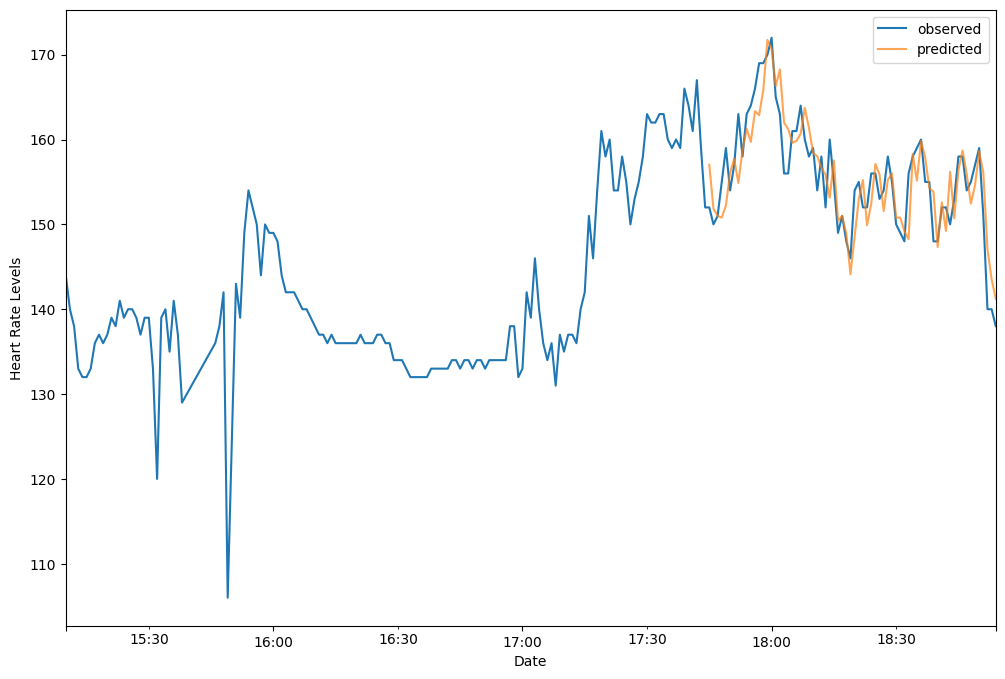

In [ ]:
# plot observations and predictions
ax = heart_rate_df['2015-08-17 15:10:00':]['heart_rate'].plot(label='observed', figsize=(12, 8))
sarima_prediction.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Heart Rate Levels')
plt.legend()

plt.show()

In [ ]:
# Out-of-sample forecasts
forecasts = sarima_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    139.046082
2015-08-17 18:56:00    139.960124
2015-08-17 18:57:00    138.762206
2015-08-17 18:58:00    138.648995
2015-08-17 18:59:00    138.266026
2015-08-17 19:00:00    137.303589
2015-08-17 19:01:00    140.534313
2015-08-17 19:02:00    141.427619
2015-08-17 19:03:00    144.640220
2015-08-17 19:04:00    144.631362
2015-08-17 19:05:00    142.352115
2015-08-17 19:06:00    142.348326
2015-08-17 19:07:00    140.979779
2015-08-17 19:08:00    142.806192
2015-08-17 19:09:00    143.721267
2015-08-17 19:10:00    143.263593
2015-08-17 19:11:00    145.549090
2015-08-17 19:12:00    143.720669
2015-08-17 19:13:00    146.462904
2015-08-17 19:14:00    142.806816
Freq: min, Name: predicted_mean, dtype: float64


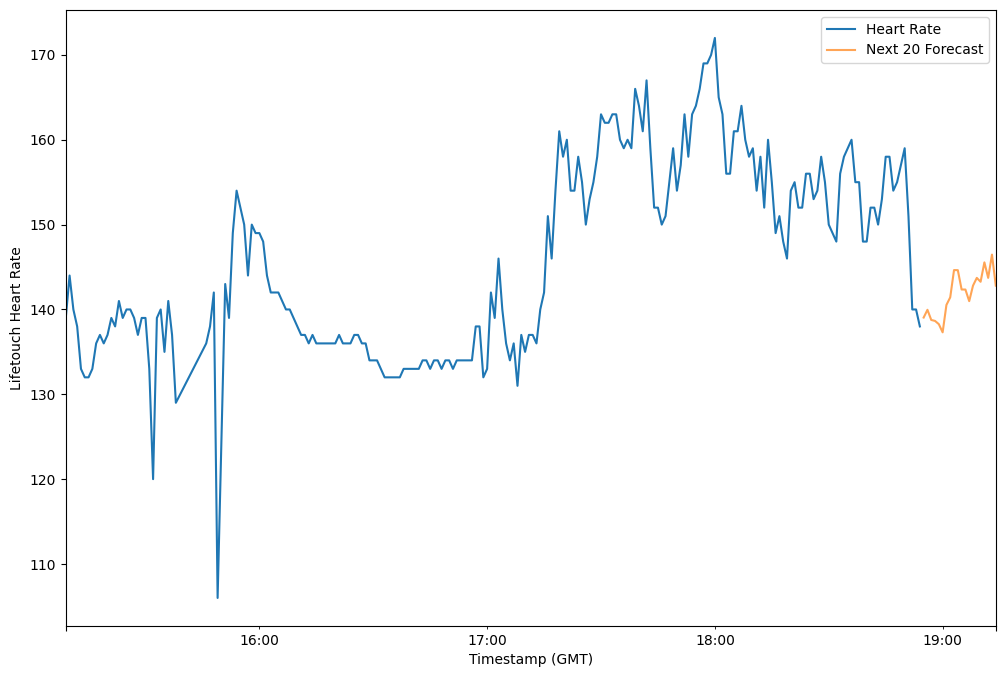

In [ ]:
# plot observations and predictions
ax = heart_rate_df['heart_rate'].plot(label='Heart Rate', figsize=(12, 8))
forecasts.plot(ax=ax, label='Next 20 Forecast', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# Create DataFrame with index 1-20 and forecasted values rounded to 2 decimal places
forecast_df = pd.DataFrame({
    'index': range(1, 21),
    'label': [round(f, 2) for f in forecasts]  # or forecasts.round(2) if forecasts is a pandas Series
}).set_index('index')

# Save to CSV
forecast_df.to_csv('heart_rate_forecast.csv')

# Display the DataFrame (for verification)
print(forecast_df)

        label
index        
1      139.05
2      139.96
3      138.76
4      138.65
5      138.27
6      137.30
7      140.53
8      141.43
9      144.64
10     144.63
11     142.35
12     142.35
13     140.98
14     142.81
15     143.72
16     143.26
17     145.55
18     143.72
19     146.46
20     142.81


##**MODEL 2 -  SARIMAX**

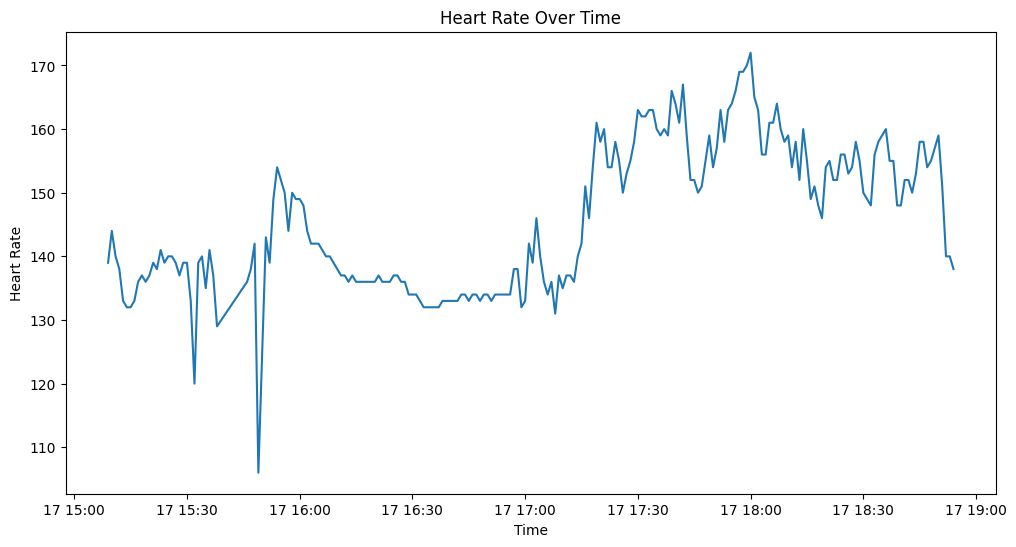

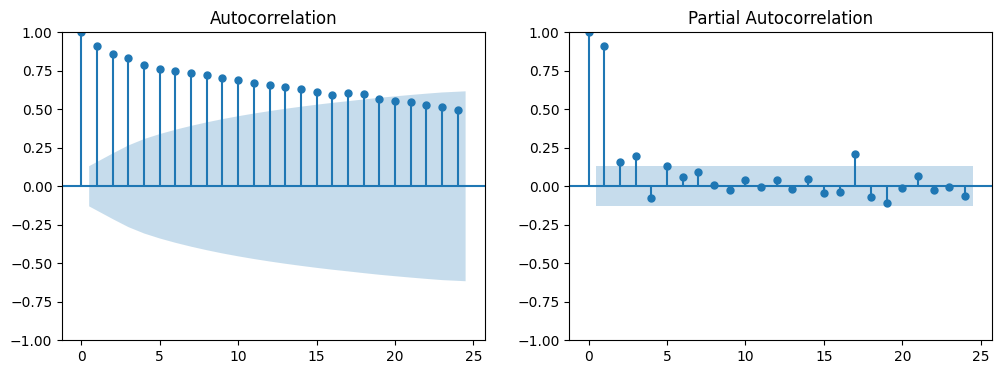

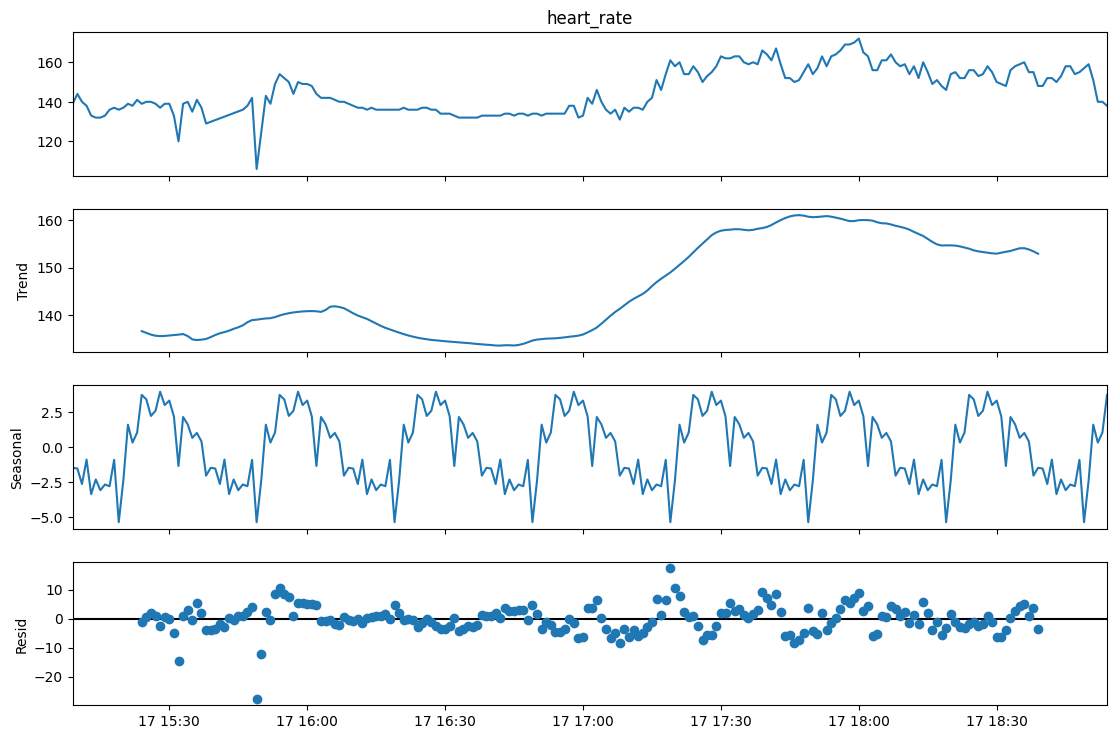

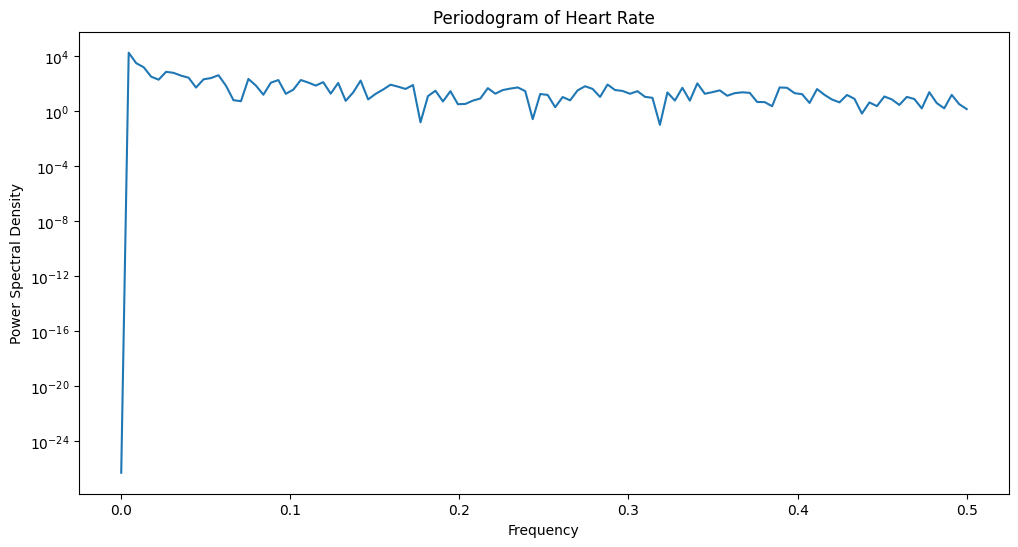

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# ... (Your data loading and cleaning code) ...

# 1. Visual Inspection:
plt.figure(figsize=(12, 6))
plt.plot(heart_rate_df['heart_rate'])
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.show()

# 2. ACF and PACF:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(heart_rate_df['heart_rate'].dropna(), ax=axes[0])
plot_pacf(heart_rate_df['heart_rate'].dropna(), ax=axes[1])
plt.show()

# 3. Seasonal Decomposition:
decomposition = seasonal_decompose(heart_rate_df['heart_rate'].dropna(), model='additive', period=30)  # Experiment with different periods
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 4. Spectral Analysis (Periodogram):
from scipy import signal
f, Pxx_den = signal.periodogram(heart_rate_df['heart_rate'].dropna())
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.title('Periodogram of Heart Rate')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.show()

Granger Causality Test for respiration_rate:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.0856 , p=0.0006  , df_denom=222, df_num=1
ssr based chi2 test:   chi2=12.2489 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9271 , p=0.0006  , df=1
parameter F test:         F=12.0856 , p=0.0006  , df_denom=222, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5716  , p=0.0113  , df_denom=219, df_num=2
ssr based chi2 test:   chi2=9.3520  , p=0.0093  , df=2
likelihood ratio test: chi2=9.1620  , p=0.0102  , df=2
parameter F test:         F=4.5716  , p=0.0113  , df_denom=219, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4695  , p=0.2238  , df_denom=216, df_num=3
ssr based chi2 test:   chi2=4.5513  , p=0.2078  , df=3
likelihood ratio test: chi2=4.5055  , p=0.2118  , df=3
parameter F test:         F=1.4695  , p=0.2238  , df_denom=216, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

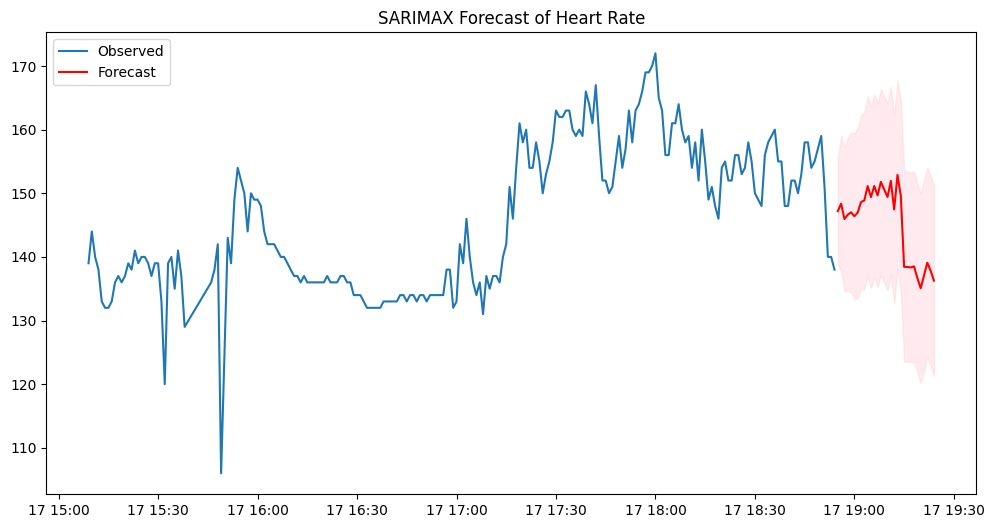

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

# # Load dataset (Ensure 'Timestamp (GMT)' is datetime)
# heart_rate_df['Timestamp (GMT)'] = pd.to_datetime(heart_rate_df['Timestamp (GMT)'])
# heart_rate_df.set_index('Timestamp (GMT)', inplace=True)

# # Forward fill missing values (Assumption: previous values are valid)
# heart_rate_df.fillna(method='ffill', inplace=True)

# Select variables
y = heart_rate_df['heart_rate']  # Dependent variable
exog = heart_rate_df[['respiration_rate', 'oximeter', 'oximeter_pulse']]  # Exogenous variables

# Granger Causality Test (Checking if exogenous variables influence heart rate)
max_lag = 5  # Number of lags to test
for col in exog.columns:
    print(f"Granger Causality Test for {col}:")
    grangercausalitytests(heart_rate_df[['heart_rate', col]], max_lag, verbose=True)

# Fit SARIMAX Model with Exogenous Variables
sarimax_model = sm.tsa.SARIMAX(y, exog=exog, order=(1,0,3), seasonal_order=(1,0,2,60))
sarimax_result = sarimax_model.fit()

# Forecasting
forecast_steps = 30  # Predict next 30 time steps
forecast = sarimax_result.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_ci = forecast.conf_int()

# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(y, label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMAX Forecast of Heart Rate")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         heart_rate   No. Observations:                  226
Model:             SARIMAX(1, 0, 3)x(1, 0, 3, 60)   Log Likelihood                -109.156
Date:                            Thu, 27 Feb 2025   AIC                            240.313
Time:                                    23:17:38   BIC                            259.427
Sample:                                08-17-2015   HQIC                           247.319
                                     - 08-17-2015                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
respiration_rate    -0.0126      0.006     -1.938      0.053      -0.025       0.000
oximeter_pulse   

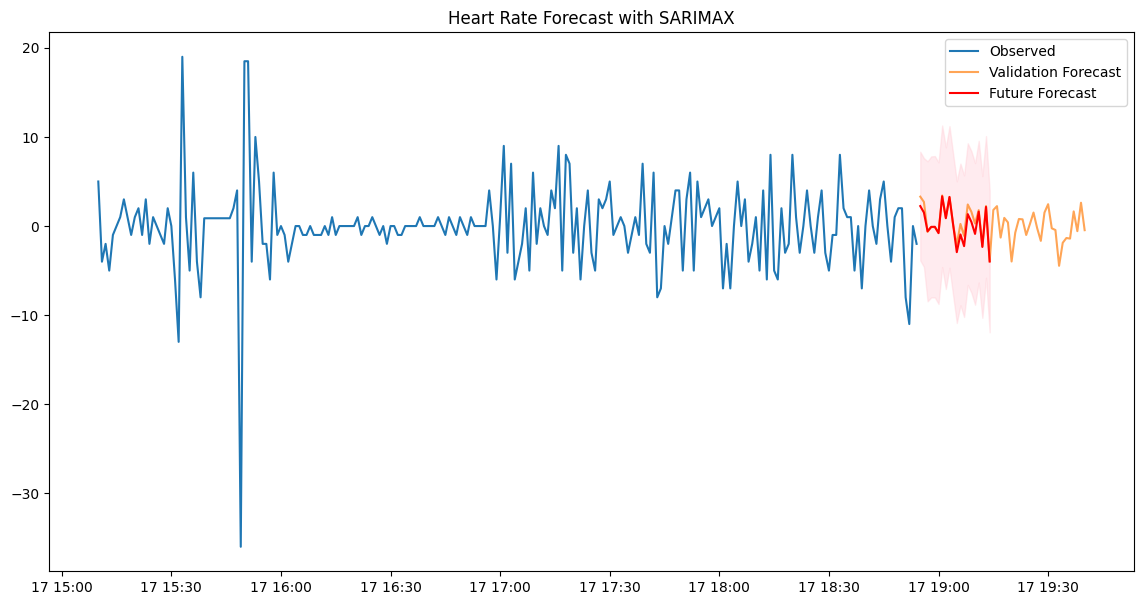

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Data Loading and Cleaning
# df = pd.read_csv('PT_Train.csv')
# df['Timestamp'] = pd.to_datetime(df['Timestamp (GMT)'], format='%d/%m/%Y %H:%M')
# df = df.sort_values('Timestamp').set_index('Timestamp')

# # Clean physiological impossibilities
# cols = ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate',
#         'Oximeter SpO2', 'Oximeter Pulse']
# df[cols] = df[cols].apply(lambda x: np.where((x < 40) | (x > 220), np.nan, x))

# 2. Stationarity Check and Differencing
def make_stationary(series):
    result = adfuller(series)
    if result[1] > 0.05:
        return series.diff()
    return series

heart_rate = make_stationary(heart_rate_df['heart_rate'])

# 3. Exogenous Variable Selection (Respiration Rate & Pulse)
exog_vars = heart_rate_df[['respiration_rate']].interpolate()

# 4. SARIMAX Model Fitting
best_model = SARIMAX(heart_rate,
                    exog=exog_vars,
                    order=(1,1,3),
                    seasonal_order=(1,0,3,60),
                    enforce_stationarity=False).fit(disp=False)

print(best_model.summary())

# 5. Model Validation
train_size = int(len(heart_rate)*0.8)
train, test = heart_rate[:train_size], heart_rate[train_size:]
exog_train, exog_test = exog_vars[:train_size], exog_vars[train_size:]

forecast = best_model.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean

# 6. Error Metrics
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
rae = np.mean(np.abs(test - forecast_mean)) / np.mean(np.abs(test - np.mean(test)))

print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, RAE: {rae:.2%}')

# 7. Final Forecast (Next 20 Minutes)
future_exog = exog_vars[-20:].values  # Requires actual future exogenous values
final_forecast = best_model.get_forecast(steps=20, exog=future_exog)

# 8. Plotting
plt.figure(figsize=(14,7))
plt.plot(heart_rate, label='Observed')
plt.plot(forecast_mean, label='Validation Forecast', alpha=0.7)
plt.plot(final_forecast.predicted_mean, label='Future Forecast', color='red')
plt.fill_between(final_forecast.conf_int().index,
                final_forecast.conf_int().iloc[:,0],
                final_forecast.conf_int().iloc[:,1],
                color='pink', alpha=0.3)
plt.title('Heart Rate Forecast with SARIMAX')
plt.legend()
plt.show()

In [ ]:
heart_rate_df = heart_rate_df.asfreq('min')
# specify model
sarimax_model = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
                                  order=(1, 1, 3),
                                  seasonal_order=(1, 0, 3, 60),
                                  exog=heart_rate_df[['respiration_rate']],  # Exogenous variable
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train the sarima model
sarimax_results = sarimax_model.fit()
# Print model summary
print(sarimax_results.summary())

# predict
sarimax_predict= sarimax_results.predict(start=pd.to_datetime('2015-08-17 17:45:00'), end=pd.to_datetime('2015-08-17 18:54:00'))

# calculate MSE
actuals = heart_rate_df['2015-08-17 17:45:00':'2015-08-17 18:54:00']['heart_rate']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, sarimax_predict ), 2)}')
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, sarimax_predict ), 2)}')
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, sarimax_predict )), 2)}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                         heart_rate   No. Observations:                  226
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 60)   Log Likelihood                -105.426
Date:                            Fri, 28 Feb 2025   AIC                            230.852
Time:                                    12:21:40   BIC                            247.988
Sample:                                08-17-2015   HQIC                           237.092
                                     - 08-17-2015                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
respiration_rate    -0.1061      0.117     -0.904      0.366      -0.336       0.124
ar.L1            

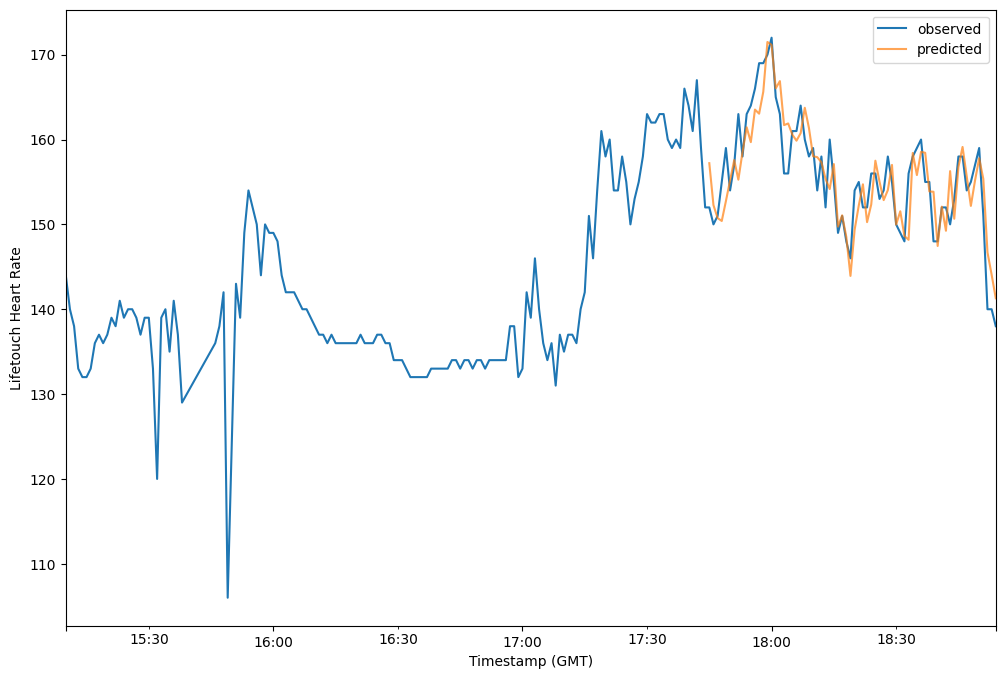

In [ ]:
# plot observations and predictions
ax = heart_rate_df['2015-08-17 15:10:00':]['heart_rate'].plot(label='observed', figsize=(12, 8))
sarimax_predict.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# Out-of-sample forecasts
# Assuming heart_rate_df has the exogenous variable 'respiration_rate'
future_exog = heart_rate_df[['respiration_rate']].iloc[-20:].values  # Get last 20 values of respiration_rate

# Provide future exogenous values to forecast
sarimax_forecasts = sarimax_results.forecast(steps=20, exog=future_exog)
print(sarimax_forecasts)

2015-08-17 18:55:00    140.597441
2015-08-17 18:56:00    140.399571
2015-08-17 18:57:00    139.457731
2015-08-17 18:58:00    139.382701
2015-08-17 18:59:00    138.666727
2015-08-17 19:00:00    138.367467
2015-08-17 19:01:00    140.953800
2015-08-17 19:02:00    141.574636
2015-08-17 19:03:00    144.963200
2015-08-17 19:04:00    145.371932
2015-08-17 19:05:00    143.150914
2015-08-17 19:06:00    143.482168
2015-08-17 19:07:00    142.091682
2015-08-17 19:08:00    143.405850
2015-08-17 19:09:00    144.590984
2015-08-17 19:10:00    143.990129
2015-08-17 19:11:00    144.968055
2015-08-17 19:12:00    143.415359
2015-08-17 19:13:00    146.747686
2015-08-17 19:14:00    143.749124
Freq: min, Name: predicted_mean, dtype: float64


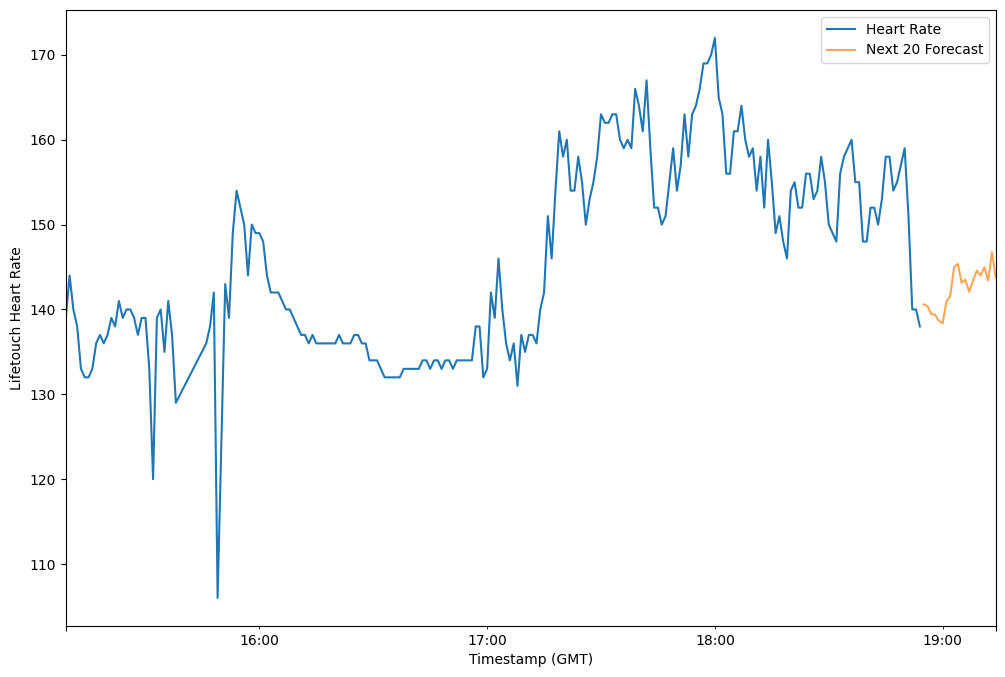

In [ ]:
# plot observations and predictions
ax = heart_rate_df['heart_rate'].plot(label='Heart Rate', figsize=(12, 8))
sarimax_forecasts.plot(ax=ax, label='Next 20 Forecast', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Prepare Data (assuming heart_rate_df is already loaded)
heart_rate = heart_rate_df['heart_rate'].copy()
exog_vars = heart_rate_df[['respiration_rate', 'oximeter_pulse']]

# 2. Fit SARIMAX on Full Dataset
model = SARIMAX(heart_rate,
                exog=exog_vars,
                order=(1,0,3),
                seasonal_order=(1,0,3,60),
                enforce_stationarity=False).fit(disp=False)

# 3. Get In-Sample Predictions
fitted_values = model.fittedvalues

# 4. Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(heart_rate, label='Actual Heart Rate', alpha=0.7)
plt.plot(fitted_values, label='Model Predictions', linestyle='--')
plt.title('Full Dataset: Actual vs Predicted Values')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()

# 5. Generate 20-Minute Forecast
future_steps = 20
last_exog = exog_vars[-future_steps:].values  # Use last available exog values
forecast = model.get_forecast(steps=future_steps, exog=last_exog)

# 6. Create Forecast DataFrame
forecast_df = pd.DataFrame({
    'Label': np.round(forecast.predicted_mean.values, 1)
}, index=range(1, 21))

# 7. Save and Display Forecast
forecast_df.to_csv('heart_rate_forecast.csv', index_label='Index')
print("Next 20-Minute Forecast:\n", forecast_df)

# 8. Plot Forecast Extension
plt.figure(figsize=(12,6))
plt.plot(heart_rate, label='Historical Data')
plt.plot(forecast.predicted_mean, label='Future Forecast', color='red')
plt.fill_between(forecast.conf_int().index,
                forecast.conf_int().iloc[:,0],
                forecast.conf_int().iloc[:,1],
                color='pink', alpha=0.3)
plt.title('20-Minute Heart Rate Forecast Projection')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()


##**MODEL 3 -  EXPONENTIAL SMOOTHING**


1.   Single Exponential Smoothing
1.   Double Exponential Smoothing
2.   Tripple Exponential Smoothing





In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
# load the data set
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1qGL_DhVTU0Nc36Sl-I5VxHqyedJX5_zi')

In [ ]:
df.columns = df.columns.str.strip() # remove unexpected spaces
df = df.rename(columns={"Timestamp (GMT)": "timestamp_gmt", "Lifetouch Heart Rate": "heart_rate"})
df.head()

,timestamp_gmt,heart_rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
#Converting Timestamp (GMT) to a datetime format
df['timestamp_gmt']=pd.to_datetime(df['timestamp_gmt'])
df.set_index('timestamp_gmt', inplace=True)
df

,heart_rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
#Dropping unwanted columns
df = df.drop(columns=['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'])
df

,heart_rate
timestamp_gmt,
2015-08-17 15:09:00,139
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
...,...
2015-08-17 18:50:00,159
2015-08-17 18:51:00,151
2015-08-17 18:52:00,140


In [ ]:
# Detect Outliers Using IQR Method

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df["heart_rate"].quantile(0.25)
Q3 = df["heart_rate"].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df["heart_rate"] < lower_bound) | (df["heart_rate"] > upper_bound)]

# Display outliers
outliers, outliers.shape

(                     heart_rate
 timestamp_gmt                  
 2015-08-17 15:39:00       61441
 2015-08-17 15:40:00       61442
 2015-08-17 15:41:00       61441
 2015-08-17 15:42:00       61441
 2015-08-17 15:43:00       61441
 2015-08-17 15:44:00       61441
 2015-08-17 15:45:00       61442
 2015-08-17 15:50:00       61442,
 (8, 1))

In [ ]:
# Replace extreme outliers with NaN
df.loc[(df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# Drop rows that now contain NaN values in the 'heart_rate' column
df.dropna(subset=["heart_rate"], inplace=True)

# Verify if any rows with extreme outliers remain
outliers_after_cleaning = df[df["heart_rate"] > upper_bound]
print(outliers_after_cleaning)


Empty DataFrame
Columns: [heart_rate]
Index: []


In [ ]:
# Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Resample data to 1-minute intervals using the mean
df = df.resample("1T").mean()

# Drop any rows with missing values (if desired)
df.dropna(inplace=True)

# Check the first few rows of the resampled DataFrame
print(df.head())

                     heart_rate
timestamp_gmt                  
2015-08-17 15:09:00       139.0
2015-08-17 15:10:00       144.0
2015-08-17 15:11:00       140.0
2015-08-17 15:12:00       138.0
2015-08-17 15:13:00       133.0


In [ ]:
df['time_diff'] = df.index.to_series().diff().dropna()  # Calculate time differences
print(df['time_diff'].value_counts())  # Check unique time gaps

time_diff
0 days 00:01:00    215
0 days 00:08:00      1
0 days 00:02:00      1
Name: count, dtype: int64


In [ ]:
# Create a complete 1-minute timestamp range
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1T')

# Reindex the dataframe to fill missing timestamps
df = df.reindex(full_index)

# Optionally, fill missing values using forward fill (or other methods)
df['heart_rate'].fillna(method='ffill', inplace=True)

# Now check if the frequency is properly inferred
print(df.index.inferred_freq)  # Should return 'T'

min


In [ ]:
df['time_diff'] = df.index.to_series().diff().dropna()  # Calculate time differences
print(df['time_diff'].value_counts())  # Check unique time gaps

time_diff
0 days 00:01:00    225
Name: count, dtype: int64


In [ ]:
df.head(225)

,heart_rate,time_diff
2015-08-17 15:09:00,139.0,NaT
2015-08-17 15:10:00,144.0,0 days 00:01:00
2015-08-17 15:11:00,140.0,0 days 00:01:00
2015-08-17 15:12:00,138.0,0 days 00:01:00
2015-08-17 15:13:00,133.0,0 days 00:01:00
...,...,...
2015-08-17 18:49:00,157.0,0 days 00:01:00
2015-08-17 18:50:00,159.0,0 days 00:01:00
2015-08-17 18:51:00,151.0,0 days 00:01:00
2015-08-17 18:52:00,140.0,0 days 00:01:00


In [ ]:
print(df.index.min(), df.index.max())  # Check min/max timestamps
print(len(df))  # See how many rows remain

2015-08-17 15:09:00 2015-08-17 18:54:00
226


In [ ]:
print(df.index.is_monotonic_increasing)  # Should be True
print(df.index.inferred_freq)  # Should return 'T' (1-minute frequency)

True
min


In [ ]:
print(df.index.inferred_freq)  # Should return 'T' for minute-level frequency

min


In [ ]:
# Set the frequency of the date time index as Monthly start as indicated by the data
heart_rate_df.index.freq = 'min'
# Set the value of Alpha and define m (Time Period)
m = 60
alpha = 1/(2*m)

In [ ]:

# convert Timestamp to int
df['minute'] = list(range(0, len(df.index)))

df.head()

,heart_rate,time_diff,HWES1,HWES2_ADD,HWES2_MUL,minute
2015-08-17 15:09:00,139.0,NaT,139.000000,139.897310,139.910989,0
2015-08-17 15:10:00,144.0,0 days 00:01:00,139.000000,139.199340,139.152948,1
2015-08-17 15:11:00,140.0,0 days 00:01:00,139.041667,142.897021,142.837439,2
2015-08-17 15:12:00,138.0,0 days 00:01:00,139.049653,140.656391,140.592018,3
2015-08-17 15:13:00,133.0,0 days 00:01:00,139.040906,138.601393,138.536822,4


Single Exponential Smoothing

<Figure size 1200x800 with 0 Axes>

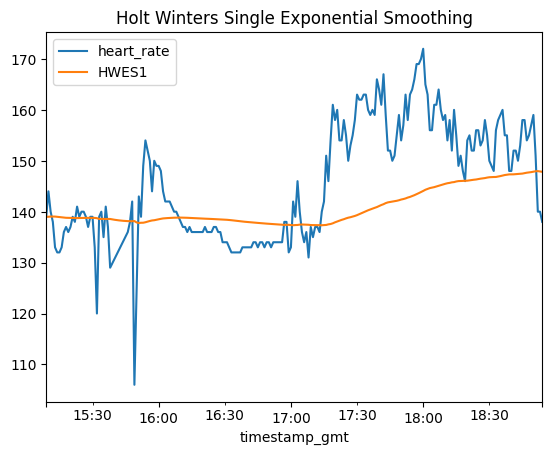

In [ ]:
plt.figure(figsize=(12, 8))
heart_rate_df['HWES1'] = SimpleExpSmoothing(heart_rate_df['heart_rate']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
heart_rate_df[['heart_rate','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

Double Exponential Smoothing

<Figure size 1200x800 with 0 Axes>

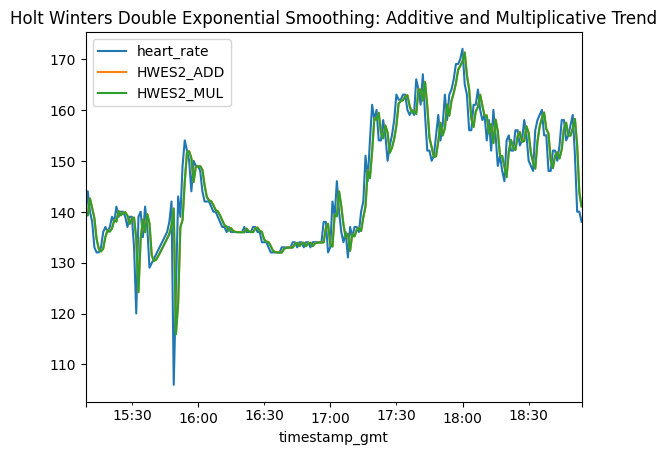

In [ ]:
plt.figure(figsize=(12, 8))
heart_rate_df['HWES2_ADD'] = ExponentialSmoothing(heart_rate_df['heart_rate'],trend='add').fit().fittedvalues
heart_rate_df['HWES2_MUL'] = ExponentialSmoothing(heart_rate_df['heart_rate'],trend='mul').fit().fittedvalues
heart_rate_df[['heart_rate','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

Triple Exponential Smoothing

<Figure size 1200x800 with 0 Axes>

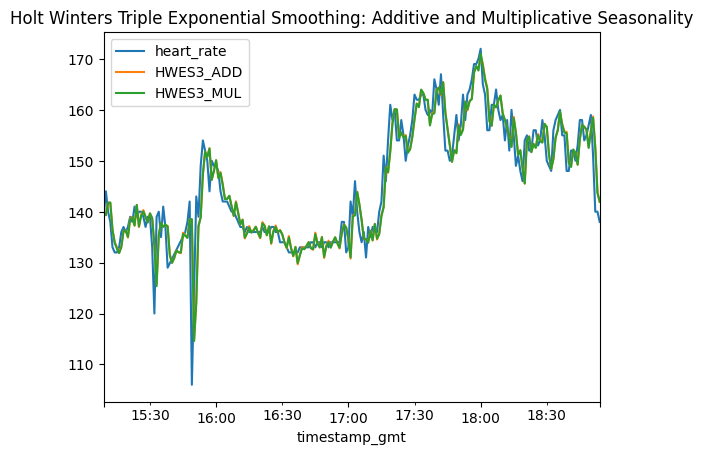

In [ ]:
plt.figure(figsize=(12, 8))
heart_rate_df['HWES3_ADD'] = ExponentialSmoothing(heart_rate_df['heart_rate'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
heart_rate_df['HWES3_MUL'] = ExponentialSmoothing(heart_rate_df['heart_rate'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
heart_rate_df[['heart_rate','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

In [ ]:
# Split into train and test set
train_heart_rate = df[:150]
test_heart_rate = df[150:]

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

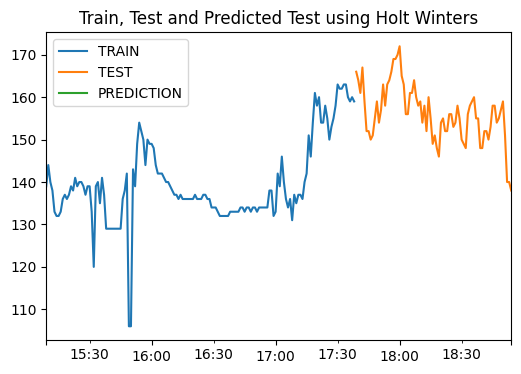

In [ ]:
fitted_model = ExponentialSmoothing(train_heart_rate['heart_rate'], trend='add',  # Change from 'mul' to 'add'
    seasonal='add',  # Change from 'mul' to 'add'
    seasonal_periods=30).fit()
test_predictions = fitted_model.forecast()
train_heart_rate['heart_rate'].plot(legend=True,label='TRAIN')
test_heart_rate['heart_rate'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
# single exponential smoothing
single_fit = SimpleExpSmoothing(heart_rate_df['heart_rate']).fit()

# double exponential smoothing
double_fit = Holt(heart_rate_df['heart_rate']).fit()

# triple exponential smoothing
holt_winters = ExponentialSmoothing(heart_rate_df['heart_rate'], trend="mul",seasonal="mul", seasonal_periods=12).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [ ]:
# future predictions
predictions_single_fit = single_fit.forecast(20)
predictions_double_fit = double_fit.forecast(20)
predictions_tripple_fit = holt_winters.forecast(20)

In [ ]:
holt_winters_prediction = holt_winters.predict(start=pd.to_datetime('2015-08-17 17:45:00'), end=pd.to_datetime('2015-08-17 18:54:00'))

In [ ]:

# calculate MSE
# actuals = heart_rate_df.loc['2015-08-17 15:12:00':, 'heart_rate']
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, holt_winters_prediction), 2)}')

# calculate the RMSE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, holt_winters_prediction)), 2)}')

# calculate the MAE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, holt_winters_prediction), 2)}')

Mean Squared Error: 16.08
Root Mean Squared Error: 4.01
Mean Absolute Error: 3.23


In [ ]:

# future predictions
holt_winters_forecast = holt_winters.forecast(steps=20)
print(holt_winters_forecast)

2015-08-17 18:55:00    138.601076
2015-08-17 18:56:00    137.522780
2015-08-17 18:57:00    139.537360
2015-08-17 18:58:00    139.569718
2015-08-17 18:59:00    138.606088
2015-08-17 19:00:00    139.902947
2015-08-17 19:01:00    137.401580
2015-08-17 19:02:00    137.370046
2015-08-17 19:03:00    137.612803
2015-08-17 19:04:00    137.273104
2015-08-17 19:05:00    137.628324
2015-08-17 19:06:00    138.596480
2015-08-17 19:07:00    138.148942
2015-08-17 19:08:00    137.074163
2015-08-17 19:09:00    139.082172
2015-08-17 19:10:00    139.114424
2015-08-17 19:11:00    138.153938
2015-08-17 19:12:00    139.446566
2015-08-17 19:13:00    136.953359
2015-08-17 19:14:00    136.921927
Freq: min, dtype: float64


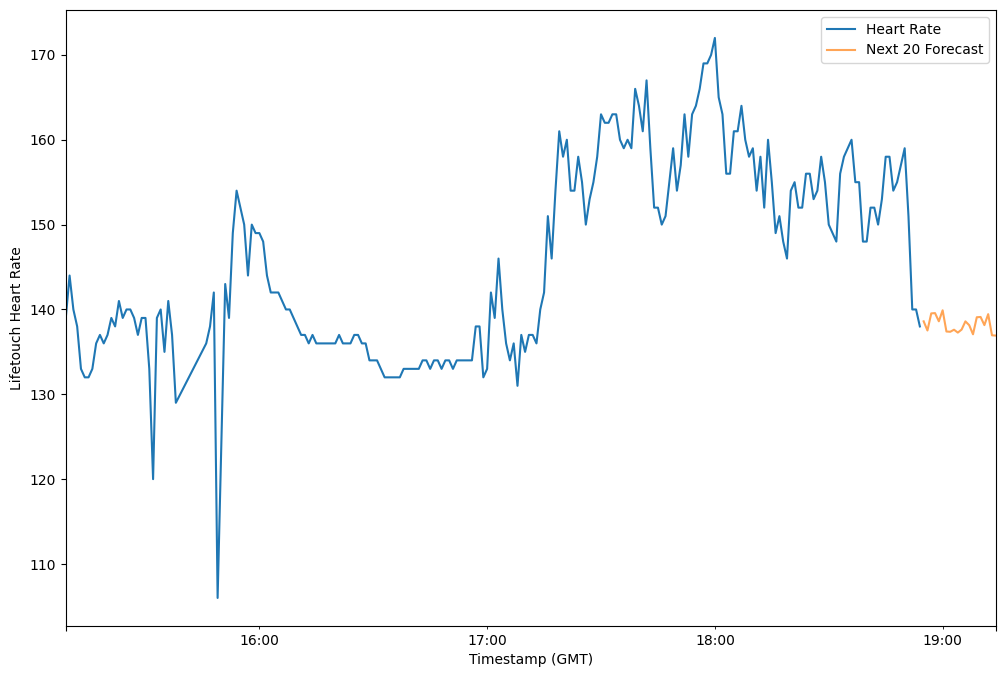

In [ ]:
# plot observations and predictions for the forecast
ax = heart_rate_df['heart_rate'].plot(label='Heart Rate', figsize=(12, 8))
holt_winters_forecast.plot(ax=ax, label='Next 20 Forecast', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

ANOTHER HOLT WINTERS

In [ ]:
# Split data (70-30 split)
train_size = int(len(df['heart_rate']) * 0.7)
train = df['heart_rate'].iloc[:train_size]
validation = df['heart_rate'].iloc[train_size:]

In [ ]:
# Fit Holt-Winters’ Exponential Smoothing (seasonal_periods=60 for hourly seasonality)
model_hw = ExponentialSmoothing(
    train,
    trend='add',          # Additive trend
    seasonal='add',       # Additive seasonality (use 'mul' for multiplicative)
    seasonal_periods=30   # 60-minute seasonality
).fit()

# Forecast validation set
hw_pred = model_hw.forecast(len(validation))

# Evaluate MSE
mse_hw = mean_squared_error(validation, hw_pred)
print(f'MSE: {mse_hw:.2f}')

MSE: 60.01


In [ ]:
# Refit model on full dataset
final_model_hw = ExponentialSmoothing(
    df['heart_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Predict next 20 minutes
forecast_hw = final_model_hw.forecast(20)

# Save predictions
forecast_hw.to_csv('holt_winters_predictions.csv')
print("Next 20 Heart Rate Predictions:")
print(forecast_hw)

Next 20 Heart Rate Predictions:
2015-08-17 18:55:00    138.172399
2015-08-17 18:56:00    136.951589
2015-08-17 18:57:00    139.187093
2015-08-17 18:58:00    139.555144
2015-08-17 18:59:00    138.555021
2015-08-17 19:00:00    139.871734
2015-08-17 19:01:00    137.240534
2015-08-17 19:02:00    136.396643
2015-08-17 19:03:00    137.817087
2015-08-17 19:04:00    137.395744
2015-08-17 19:05:00    137.764521
2015-08-17 19:06:00    138.657698
2015-08-17 19:07:00    138.140048
2015-08-17 19:08:00    136.919238
2015-08-17 19:09:00    139.154741
2015-08-17 19:10:00    139.522793
2015-08-17 19:11:00    138.522670
2015-08-17 19:12:00    139.839382
2015-08-17 19:13:00    137.208183
2015-08-17 19:14:00    136.364291
Freq: min, dtype: float64


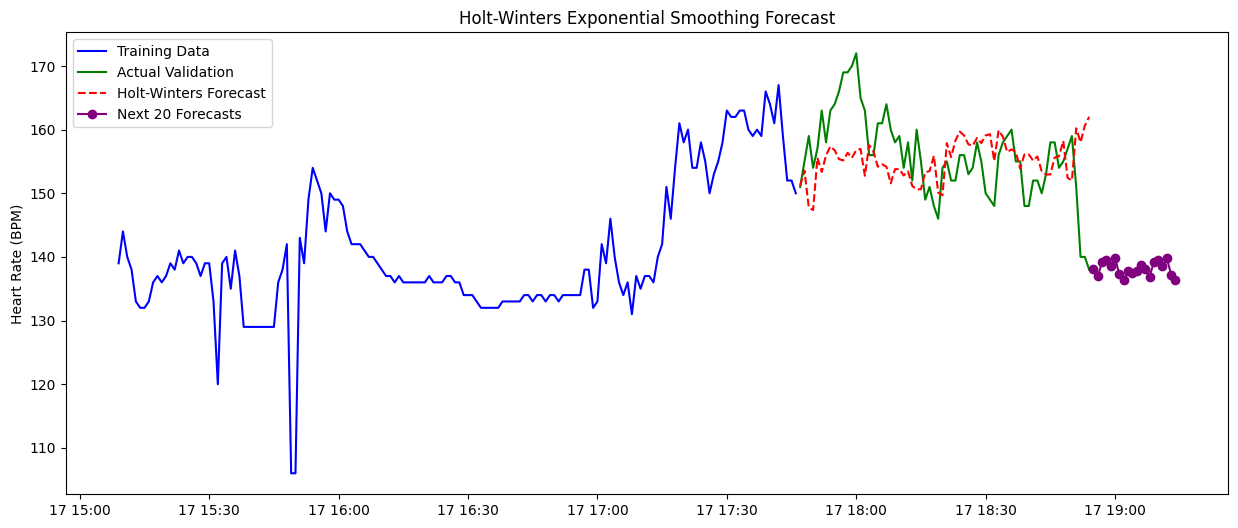

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(validation.index, validation, label='Actual Validation', color='green')
plt.plot(validation.index, hw_pred, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.plot(forecast_hw.index, forecast_hw, label='Next 20 Forecasts', color='purple', marker='o')
plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.ylabel('Heart Rate (BPM)')
plt.legend()
plt.show()

#**RESULT**

|Time Series Model | AIC | MSE   | RMSE | MAE |
|------|--------------------|------------|----------------|----------|
|**HOLT-WINTERS EXPONNENTIAL SMOOTHING**  | - | 16.08 | 4.01 | 3.23 |
|**SARIMA**   | 230.49 | 12.11  | 3.48 | 2.82 |
|**SARIMAX**  |230.49  | 11.35 | 3.37 | 2.72


##**MODEL 4 - LORENZ METHOD OF ANALOGUES**

In [ ]:
# load the data set
heart_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1qGL_DhVTU0Nc36Sl-I5VxHqyedJX5_zi')

In [ ]:
heart_df.columns = heart_df.columns.str.strip() # remove unexpected spaces
heart_df = heart_df.rename(columns={"Timestamp (GMT)": "timestamp_gmt", "Lifetouch Heart Rate": "heart_rate"})
heart_df.head()

,timestamp_gmt,heart_rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
#Converting Timestamp (GMT) to a datetime format
heart_df['timestamp_gmt']=pd.to_datetime(heart_df['timestamp_gmt'])
heart_df.set_index('timestamp_gmt', inplace=True)
heart_df

,heart_rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
#Dropping unwanted columns
heart_df = heart_df.drop(columns=['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'])
heart_df

,heart_rate
timestamp_gmt,
2015-08-17 15:09:00,139
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
...,...
2015-08-17 18:50:00,159
2015-08-17 18:51:00,151
2015-08-17 18:52:00,140


In [ ]:
# Detect Outliers Using IQR Method

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = heart_df["heart_rate"].quantile(0.25)
Q3 = heart_df["heart_rate"].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = heart_df[(heart_df["heart_rate"] < lower_bound) | (heart_df["heart_rate"] > upper_bound)]

# Display outliers
outliers, outliers.shape


(                     heart_rate
 timestamp_gmt                  
 2015-08-17 15:39:00       61441
 2015-08-17 15:40:00       61442
 2015-08-17 15:41:00       61441
 2015-08-17 15:42:00       61441
 2015-08-17 15:43:00       61441
 2015-08-17 15:44:00       61441
 2015-08-17 15:45:00       61442
 2015-08-17 15:50:00       61442,
 (8, 1))

In [ ]:
# Replace extreme outliers with NaN
heart_df.loc[(heart_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# Drop rows that now contain NaN values in the 'heart_rate' column
heart_df.dropna(subset=["heart_rate"], inplace=True)

# Verify if any rows with extreme outliers remain
outliers_after_cleaning = heart_df[heart_df["heart_rate"] > upper_bound]
print(outliers_after_cleaning)


Empty DataFrame
Columns: [heart_rate]
Index: []


In [ ]:
# 1. Ensure the index is a datetime index
heart_df.index = pd.to_datetime(heart_df.index)

# 2. Resample data to 1-minute intervals using the mean
heart_df = heart_df.resample("1T").mean()

# 3. Drop any rows with missing values (if desired)
heart_df.dropna(inplace=True)

# Check the first few rows of the resampled DataFrame
print(heart_df.head())

                     heart_rate
timestamp_gmt                  
2015-08-17 15:09:00       139.0
2015-08-17 15:10:00       144.0
2015-08-17 15:11:00       140.0
2015-08-17 15:12:00       138.0
2015-08-17 15:13:00       133.0


Test MSE: 27.504
Test RMSE: 5.244


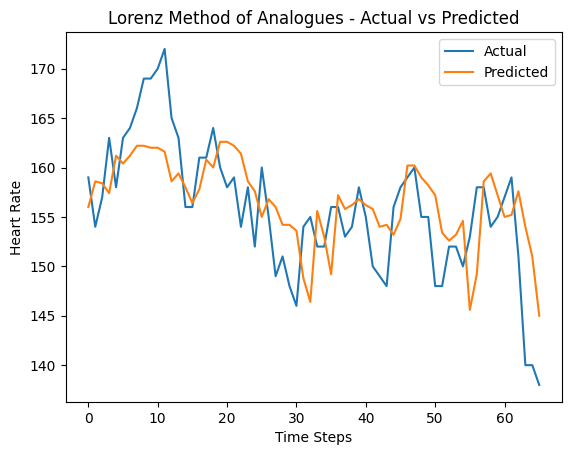


Future Predictions:
[[141. ]
 [137.8]
 [136.6]
 [137.2]
 [137.6]
 [135.8]
 [137. ]
 [135.6]
 [135.8]
 [137. ]
 [136.4]
 [137. ]
 [136.2]
 [135.8]
 [135.6]
 [136. ]
 [136.4]
 [136.4]
 [136.2]
 [136.2]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


# 2. Scaling
scaler = MinMaxScaler()
heart_rate['heart_rate_standardised'] = scaler.fit_transform(heart_df[['heart_rate']])

# 3. Dataset splitting into train and test
X = heart_rate['heart_rate_standardised'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]

# 4. Lorenz Method of Analogues Implementation
def lorenz_analogues(train, test, embedding_dimension, num_analogues):
    """
    Predicts future values using the Lorenz Method of Analogues.

    Args:
        train (np.array): Training data.
        test (np.array): Test data.
        embedding_dimension (int): The number of past values to use as features.
        num_analogues (int): The number of nearest neighbors to use for prediction.

    Returns:
        predictions (np.array): Predicted values for the test set.
    """

    # Create lagged vectors from the training data
    lagged_vectors = []
    target_values = []
    for i in range(embedding_dimension, len(train)):
        lagged_vectors.append(train[i-embedding_dimension:i])
        target_values.append(train[i])

    lagged_vectors = np.array(lagged_vectors)
    target_values = np.array(target_values)

    # Build a KD-tree from the lagged vectors
    kdtree = KDTree(lagged_vectors)

    # Predict the test data
    predictions = []
    for i in range(len(test)):
        # Create a lagged vector from the test data
        test_vector = test[max(0, i-embedding_dimension):i] #Prevent out of bounds
        if len(test_vector) < embedding_dimension:
            #Pad with values from the train set
            needed_values = embedding_dimension - len(test_vector)
            padding = train[-needed_values:]
            test_vector = np.concatenate([padding, test_vector])

        # Find the nearest neighbors in the training data
        distances, indices = kdtree.query(test_vector, k=num_analogues)

        # Predict the next value as the average of the target values of the nearest neighbors
        prediction = np.mean(target_values[indices])
        predictions.append(prediction)

    return np.array(predictions)

# 5. Set Parameters
embedding_dimension = 5
num_analogues = 5

# 6. Make Predictions
predictions = lorenz_analogues(train, test, embedding_dimension, num_analogues)

# 7. Inverse Transform Predictions
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))
test_original_scale = scaler.inverse_transform(test.reshape(-1, 1))

# 8. Evaluate Model
mse = mean_squared_error(test_original_scale, predictions_original_scale)
rmse = np.sqrt(mean_squared_error(test_original_scale, predictions_original_scale))
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

# 9. Plot Results
plt.plot(test_original_scale, label='Actual')
plt.plot(predictions_original_scale, label='Predicted')
plt.title('Lorenz Method of Analogues - Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

# 10. Future Predictions (Using the entire dataset as "train")
# Create lagged vectors from the entire dataset
X = heart_rate_df['heart_rate'].values
lagged_vectors = []
target_values = []

for i in range(embedding_dimension, len(X)):
    lagged_vectors.append(X[i-embedding_dimension:i])
    target_values.append(X[i])

lagged_vectors = np.array(lagged_vectors)
target_values = np.array(target_values)

# Build a KD-tree from the lagged vectors
kdtree = KDTree(lagged_vectors)

# Predict the next 20 values
future_predictions = []
last_known_values = X[-embedding_dimension:]  # Seed with the last known values

for _ in range(20):
    # Find the nearest neighbors to the last known values
    distances, indices = kdtree.query(last_known_values, k=num_analogues)

    # Predict the next value
    prediction = np.mean(target_values[indices])
    future_predictions.append(prediction)

    # Update the last known values by shifting and adding the new prediction
    last_known_values = np.roll(last_known_values, -1)
    last_known_values[-1] = prediction

future_predictions = np.array(future_predictions)

# Inverse Transform Future Predictions
future_predictions_original_scale = scaler.inverse_transform(future_predictions.reshape(-1, 1))
print('\nFuture Predictions:')
print(future_predictions_original_scale)

# Save predictions to CSV
np.savetxt('predictions.csv', future_predictions_original_scale, delimiter=',')
